# ----------------------------- CAB BOOKING SYSTEM -----------------------------

---

## Background
Cab booking system is the process where renting a cab is automated through an app throughout a city. Using this app, people can book a cab from one location to another location. Being a cab booking app company, exploiting the understanding of cab supply and demand could increase the efficiency of their service and enhance user experience by minimizing waiting time.

---

### Objective
Objective of this project is to combine historical usage pattern along with the open data sources like weather data to forecast cab booking demand in a city.

---

### Process Flow
 - You will be provided with hourly renting data span of two years. 
 - Data is randomly divided into train and test set. 
 - You must predict the total count of cabs booked in each hour covered by the test set, using the information available prior to the booking period. 
 - You need to append the train_label dataset to train.csv as ‘Total_booking’ column.
 
---

### Description of Columns in the Dataset
 - datetime --> hourly date + timestamp
 - season --> spring, summer, autumn, winter
 - holiday --> whether the day is considered a holiday
 - workingday --> whether the day is neither a weekend nor holiday
 - weather --> Clear , Cloudy, Light Rain, Heavy temp - temperature in Celsius atemp - "feels like" temperature in Celsius
 - humidity --> relative humidity
 - windspeed --> wind speed
 - Total_booking --> number of total booking
 
---

### Task 1 

1. Visualize data using different visualizations to generate interesting insights.
2. Outlier Analysis
3. Missing value analysis
4. Visualizing Total_booking Vs other features to generate insights
5. Correlation Analysis

---

### Task 2
1. Feature Engineering
2. Grid search
3. Regression Analysis
4. Ensemble Model

=====================================================================================================================

In [1]:
# Interactive Jupyter Imports
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Ignore the Warnings Imports
import warnings
from warnings import filterwarnings
warnings.filterwarnings('ignore')

In [3]:
# Data Analysis and Wrangling
import pandas as pd
import numpy as np
from datetime import datetime
import time

In [4]:
# IGNORING the chained_assignment warning when working on slices of dataframes
pd.options.mode.chained_assignment = None

In [5]:
# Visualization
# from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(color_codes=True, font_scale=1.1)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 7, 7

In [6]:
# Machine Learning
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

# TASK - 1

### Reading the Dataset

 - train_df = original dataframe
 - test_df = original validation dataframe
 - train_df_label = Train label dataframe
 - test_df_label = Test label dataframe

In [7]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### Adding Header to train_label and test_label dataframe

In [8]:
train_df_label = pd.read_csv('train_label.csv', names={'Total_booking'}, header=None)
test_df_label = pd.read_csv('test_label.csv', names={'Total_booking'}, header=None)

### Merging the provided Dataframes & Label Dataframes and assigning it to a new "Merged" dataframe

In [9]:
train_df_merged = pd.concat([train_df, train_df_label], axis=1)
test_df_merged = pd.concat([test_df, test_df_label], axis=1)

## Feature Extraction

 - We will extract the time and date from the datetime. 
 - We have seen earlier that the data type of Datetime is object. 
 - So first of all we have to change the data type to datetime format otherwise we can not extract features from it.

In [10]:
train_df_merged['datetime'] = pd.to_datetime(train_df_merged.datetime)
test_df_merged['datetime'] = pd.to_datetime(test_df_merged.datetime)

### Extracting the year, month, day, hour and weekday from the datetime

In [11]:
for i in (train_df_merged, test_df_merged):
    i['year'] = i.datetime.dt.year
    i['month'] = i.datetime.dt.month
    i['day'] = i.datetime.dt.day
    i['hour'] = i.datetime.dt.hour
    i['weekday'] = i.datetime.dt.weekday

### Dropping datetime column from the final dataframe

In [12]:
df = train_df_merged.drop('datetime', axis=1)
dv = test_df_merged.drop('datetime', axis=1)

 - dv and df are finalized dataframe to work upon.
 - df is training dataframe.
 - dv is validation/test dataframe

### Reordering the Columns of the final dataframe of Train and Test

In [13]:
# setting column's order
order = [9, 10, 11, 12, 13, 0, 1, 2, 3, 4,
         5, 6, 7, 8]

In [14]:
df = df[[df.columns[i] for i in order]]
dv = dv[[dv.columns[i] for i in order]]

In [15]:
df.describe()

,year,month,day,hour,weekday,holiday,workingday,temp,atemp,humidity,windspeed,Total_booking
count,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000,8708.000000
mean,2011.505168,6.528709,10.009531,11.581190,3.015618,0.028480,0.680294,20.243020,23.655552,61.649173,12.843891,193.007005
std,0.500002,3.440879,5.480540,6.890534,2.006246,0.166348,0.466389,7.813494,8.501107,19.199578,8.190314,181.552211
min,2011.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.820000,0.760000,0.000000,0.000000,1.000000
25%,2011.000000,4.000000,5.000000,6.000000,1.000000,0.000000,0.000000,13.940000,16.665000,46.000000,7.001500,43.000000
50%,2012.000000,7.000000,10.000000,12.000000,3.000000,0.000000,1.000000,20.500000,24.240000,61.000000,12.998000,148.000000
75%,2012.000000,10.000000,15.000000,18.000000,5.000000,0.000000,1.000000,26.240000,31.060000,77.000000,16.997900,286.000000
max,2012.000000,12.000000,19.000000,23.000000,6.000000,1.000000,1.000000,41.000000,45.455000,100.000000,56.996900,977.000000


In [16]:
dv.describe()

,year,month,day,hour,weekday,holiday,workingday,temp,atemp,humidity,windspeed,Total_booking
count,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000
mean,2011.488981,6.492654,9.924702,11.383379,3.007346,0.028926,0.683196,20.182241,23.653214,62.835170,12.621496,185.845271
std,0.499993,3.458952,5.461590,7.015466,1.998378,0.167636,0.465337,7.704978,8.369721,19.401161,8.060062,179.431987
min,2011.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.280000,3.790000,0.000000,0.000000,1.000000
25%,2011.000000,3.000000,5.000000,5.000000,1.000000,0.000000,0.000000,13.940000,16.665000,48.000000,7.001500,38.000000
50%,2011.000000,7.000000,10.000000,11.000000,3.000000,0.000000,1.000000,20.500000,24.240000,63.000000,11.001400,136.000000
75%,2012.000000,10.000000,15.000000,18.000000,5.000000,0.000000,1.000000,26.240000,31.060000,78.000000,16.997900,277.000000
max,2012.000000,12.000000,19.000000,23.000000,6.000000,1.000000,1.000000,38.540000,44.695000,100.000000,56.996900,901.000000


#### Insights
1. The values of the variable seems legit with Max , Min, Mean, and STD  being in legitimate ranges.
2. Total Booking Count range from 1 to 977, which mean there has been at least one booking every day.
3. Average booking per day is around 11.5 hours.
4. Average bookings recorded over 2011 and 2012 are 194 per day.
5. 50% of all the bookings happened in the year 2012.

## Missing Value Analysis

### Checking number of null value columns

In [17]:
print("The training dataframe has {0[0]} rows and {0[1]} columns. \n".format(
    df.shape))
print("The validation dataframe has {0[0]} rows and {0[1]} columns. \n".format(
    dv.shape))

The training dataframe has 8708 rows and 14 columns. 

The validation dataframe has 2178 rows and 14 columns. 



In [18]:
df.info()
dv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 14 columns):
year             8708 non-null int64
month            8708 non-null int64
day              8708 non-null int64
hour             8708 non-null int64
weekday          8708 non-null int64
season           8708 non-null object
holiday          8708 non-null int64
workingday       8708 non-null int64
weather          8708 non-null object
temp             8708 non-null float64
atemp            8708 non-null float64
humidity         8708 non-null int64
windspeed        8708 non-null float64
Total_booking    8708 non-null int64
dtypes: float64(3), int64(9), object(2)
memory usage: 952.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 14 columns):
year             2178 non-null int64
month            2178 non-null int64
day              2178 non-null int64
hour             2178 non-null int64
weekday          2178 non-null int64
season     

In [19]:
df.isna().sum()
dv.isna().sum()

year             0
month            0
day              0
hour             0
weekday          0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
Total_booking    0
dtype: int64

year             0
month            0
day              0
hour             0
weekday          0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
Total_booking    0
dtype: int64

#### Insights
1. Trainig dataset has 8708 and Validation dataset has 2178 observations without any missing values.
2. No data is missing hence entire dataset is useable.

## Data Visualization

### Cab Booking distribution yearwise

<Figure size 720x288 with 0 Axes>

Text(0.5,0,'Year')

Text(0,0.5,'Total Bookings')

Text(0.5,1,'Number of Bookings in 2011 and 2012')

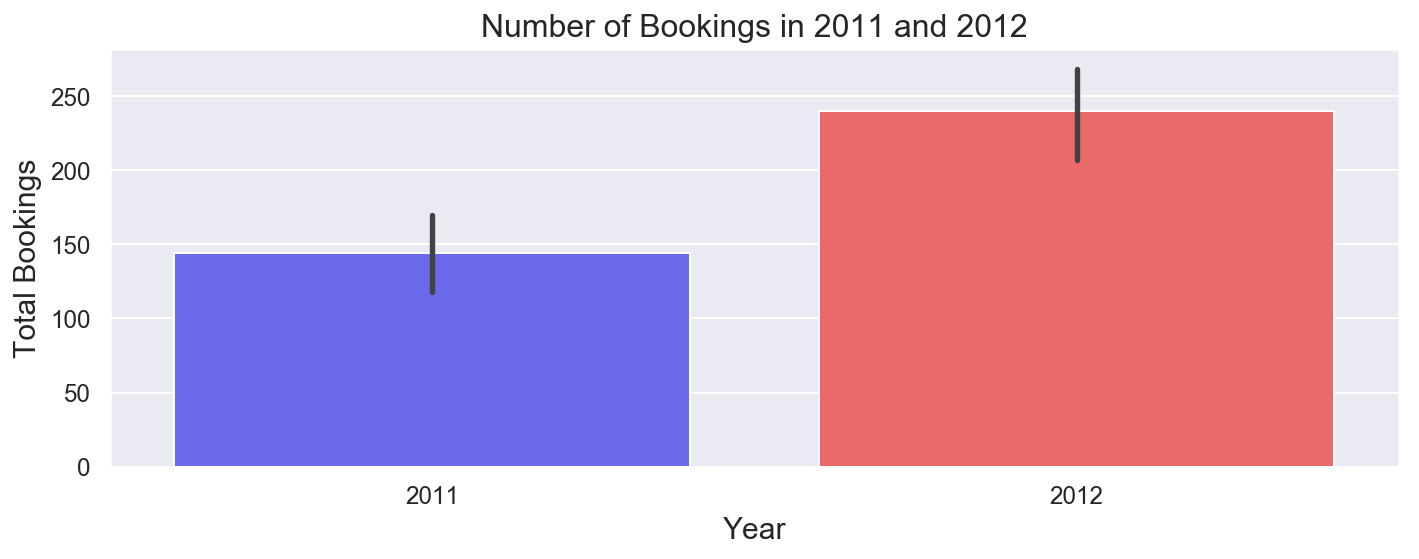

In [20]:
plt.figure(figsize=(10,4))
monthyear=pd.DataFrame(df.groupby(['year', 'month'], sort=True)['Total_booking'].mean()).reset_index()

sns.barplot(x=monthyear['year'], y=monthyear['Total_booking'], data=monthyear, palette='seismic')

plt.xlabel('Year', fontsize=15)
plt.ylabel('Total Bookings', fontsize=15)
plt.title('Number of Bookings in 2011 and 2012', fontsize=16)

plt.tight_layout()
plt.show()

#### Insights
1. The number of bookings done 2012 is significantly higher than 2011.
2. Increase in number of cab bookings over the year is the good sign for the business.

### Distribution of Total Bookings

Text(0.5,1,'Distribution of Target Variable')

Text(0.5,0,'Number of Bookings')

Text(0,0.5,'Distribution')

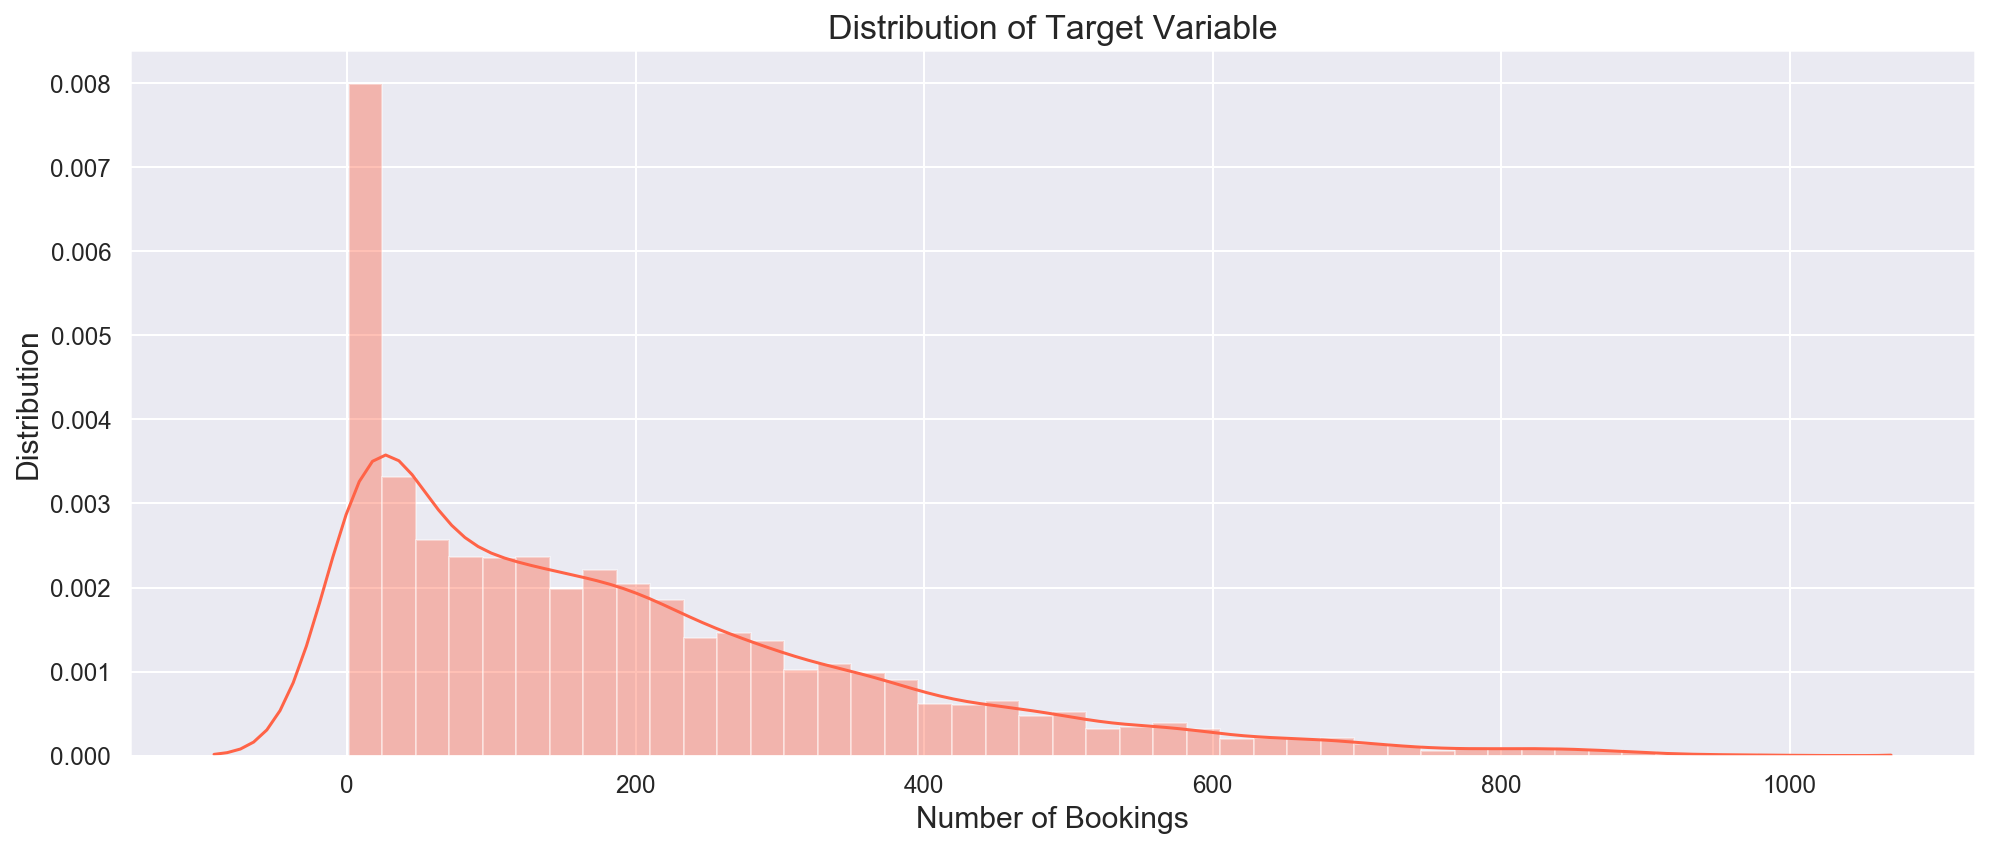

In [21]:
fig, ax0 = plt.subplots(nrows=1, figsize=(14, 6))
sns.distplot(df['Total_booking'], ax=ax0, color='tomato')

ax0.set_title('Distribution of Target Variable', fontsize=17)
ax0.set_xlabel('Number of Bookings', fontsize=15)
ax0.set_ylabel('Distribution', fontsize=15)

plt.tight_layout()
plt.show()

### Cab booking distribution monthwise, daywise and hourly

Text(0.5,0,'Months in Year')

Text(0,0.5,'Number of Bookings')

Text(0.5,1,'Total Number of Bookings (Year, Months and Days)')

Text(0.5,0,'Day of Week')

Text(0,0.5,'Number of Bookings')

Text(0.5,0,'Hour of the Day')

Text(0,0.5,'Number of Bookings')

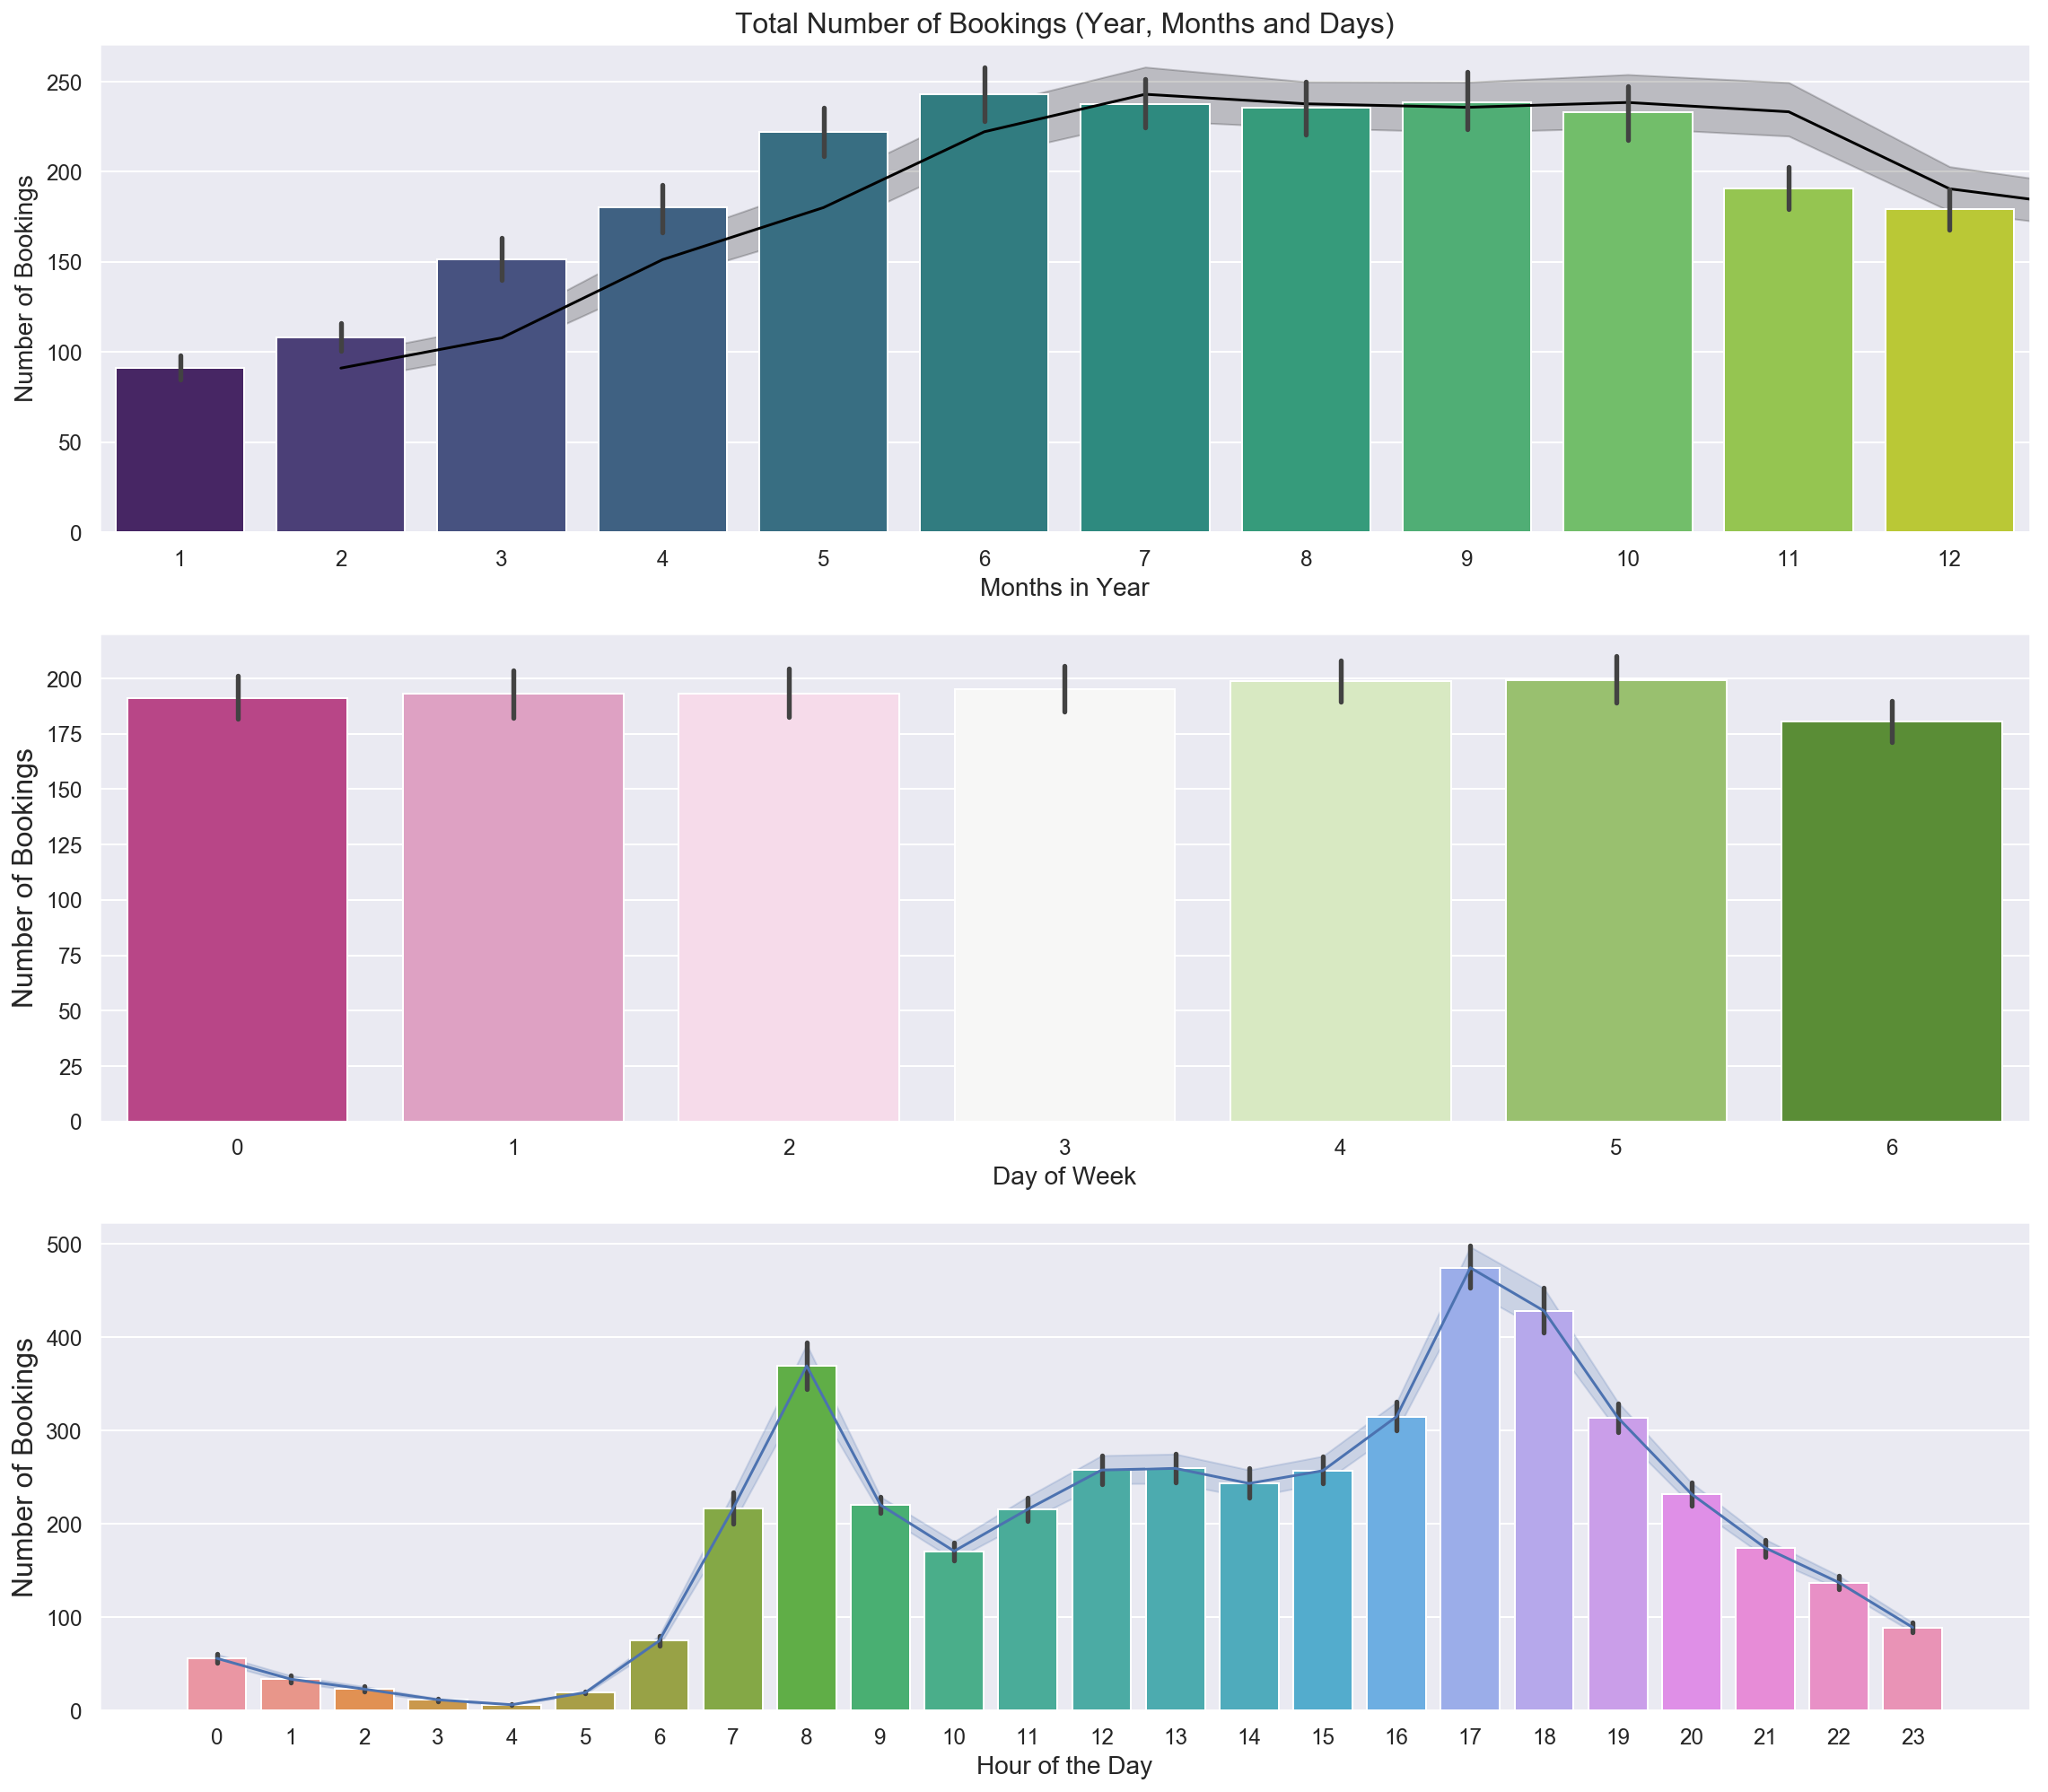

In [22]:
fig1, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(16, 14))

sns.lineplot(df.month, df['Total_booking'], ax=ax1, color='black')
sns.barplot(df.month, df['Total_booking'], ax=ax1, palette='viridis')

ax1.set_xlabel('Months in Year', fontsize=14)
ax1.set_ylabel('Number of Bookings', fontsize=14)
ax1.set_title('Total Number of Bookings (Year, Months and Days)', fontsize=16)

sns.barplot(df.weekday, df['Total_booking'], ax=ax2, palette='PiYG')
ax2.set_xlabel('Day of Week', fontsize=14)
ax2.set_ylabel('Number of Bookings', fontsize=16)

sns.barplot(df.hour, df['Total_booking'], ax=ax3)
sns.lineplot(df.hour, df['Total_booking'], ax=ax3)
ax3.set_xlabel('Hour of the Day', fontsize=14)
ax3.set_ylabel('Number of Bookings', fontsize=16)

plt.tight_layout()
plt.show()

#### Insights
1. Maximum Bookings are happening during the Fall Season and lowest is during the Spring season.
2. In the morning, at 8 AM maximum booking happens and in the evening, 5 PM registers the maximum booking.

### Cab booking distribution each season on Hourly basis

Text(0.5,0,'Seasons')

Text(0,0.5,'Number of Bookings')

Text(0.5,1,'Total Number of Bookings every Season')

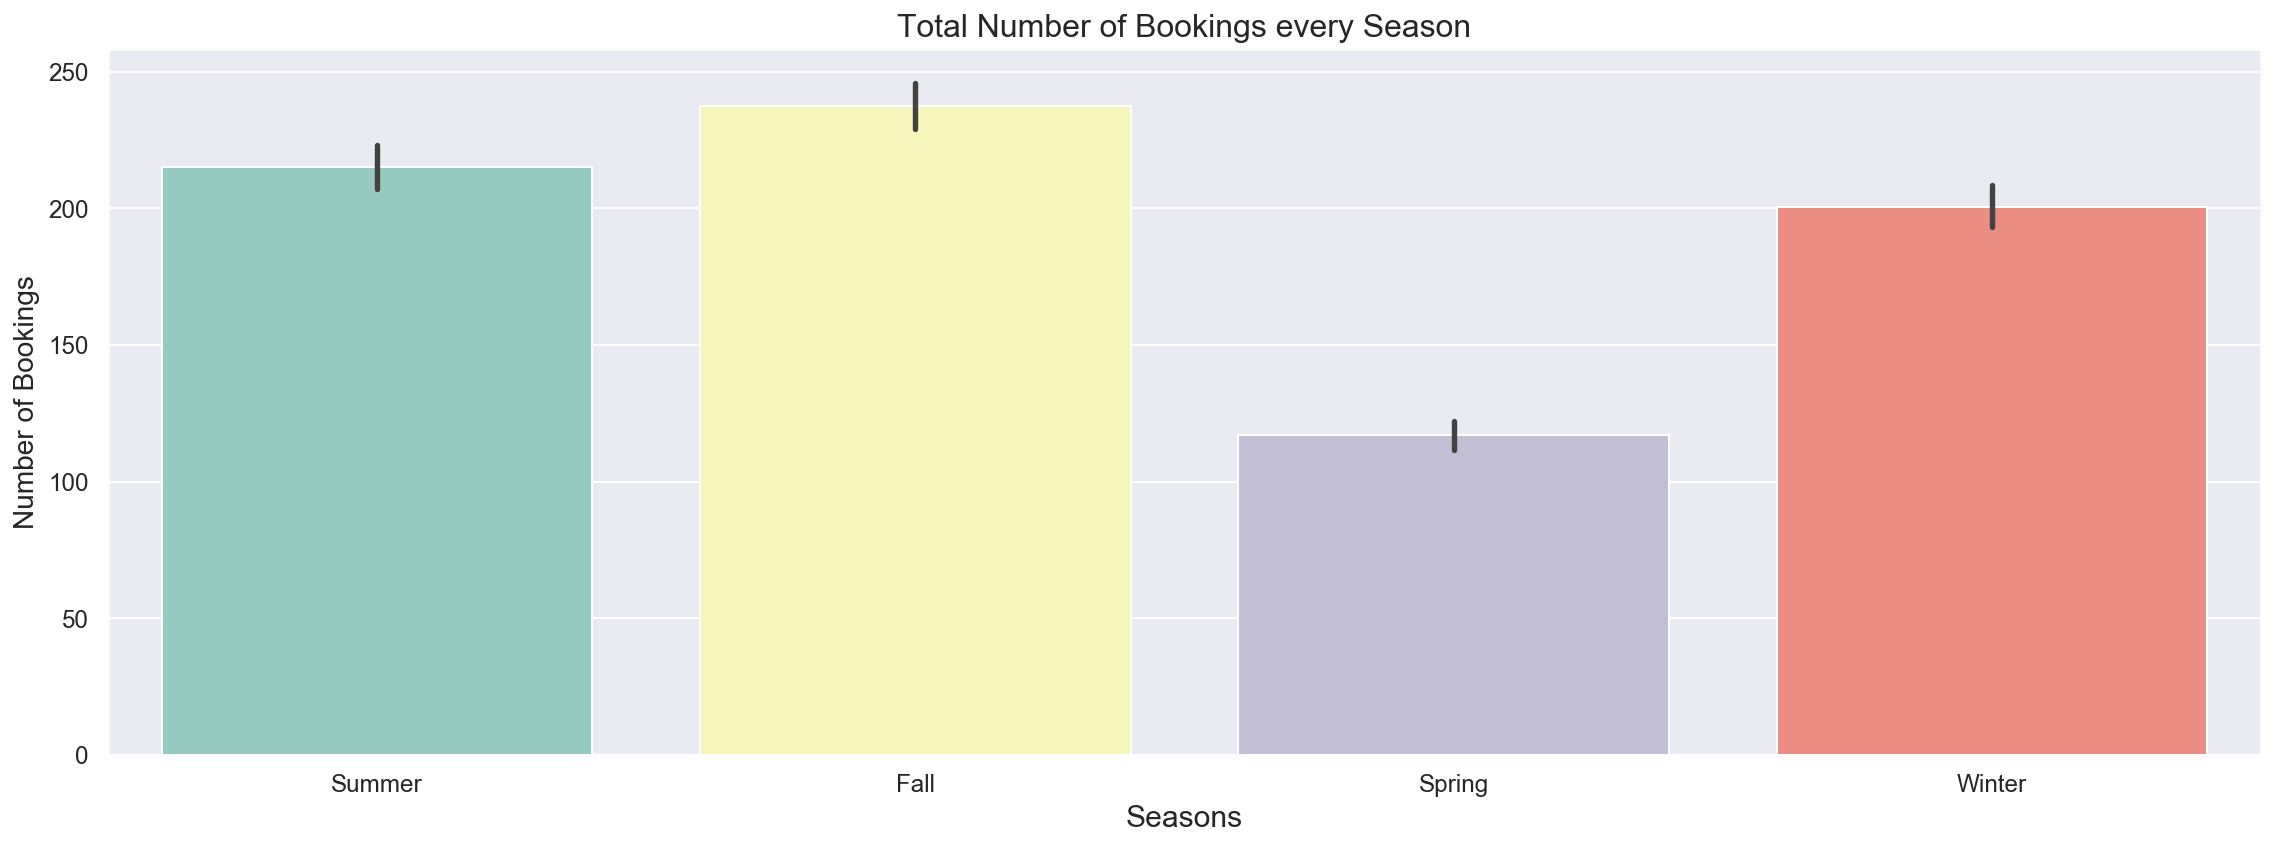

In [23]:
fig, ax4=plt.subplots(nrows=1, figsize=(16, 6))
sns.barplot(df.season, df['Total_booking'], ax=ax4, palette='Set3')

ax4.set_xlabel('Seasons', fontsize=15)
ax4.set_ylabel('Number of Bookings', fontsize=14)
ax4.set_title('Total Number of Bookings every Season', fontsize=16)

plt.tight_layout()
plt.show()

#### Insights
1. Maximum Cab booking happens during the Fall season.
2. Bookings are happening throughout the Summer, Fall and Winter seasons. 
3. Focus should be there to increase and maximize the opportunities during the Spring season.

### Cab booking distribution on Hourly basis across the Seasons

Text(0,0.5,'Total Bookings')

Text(0,0.5,'Total Bookings')

Text(0,0.5,'Total Bookings')

Text(0.5,0,'Hour of the Day')

Text(0.5,1,'Average Bookings on Hourly basis across the Seasons')

[[<matplotlib.axis.XTick at 0x1a22350310>,

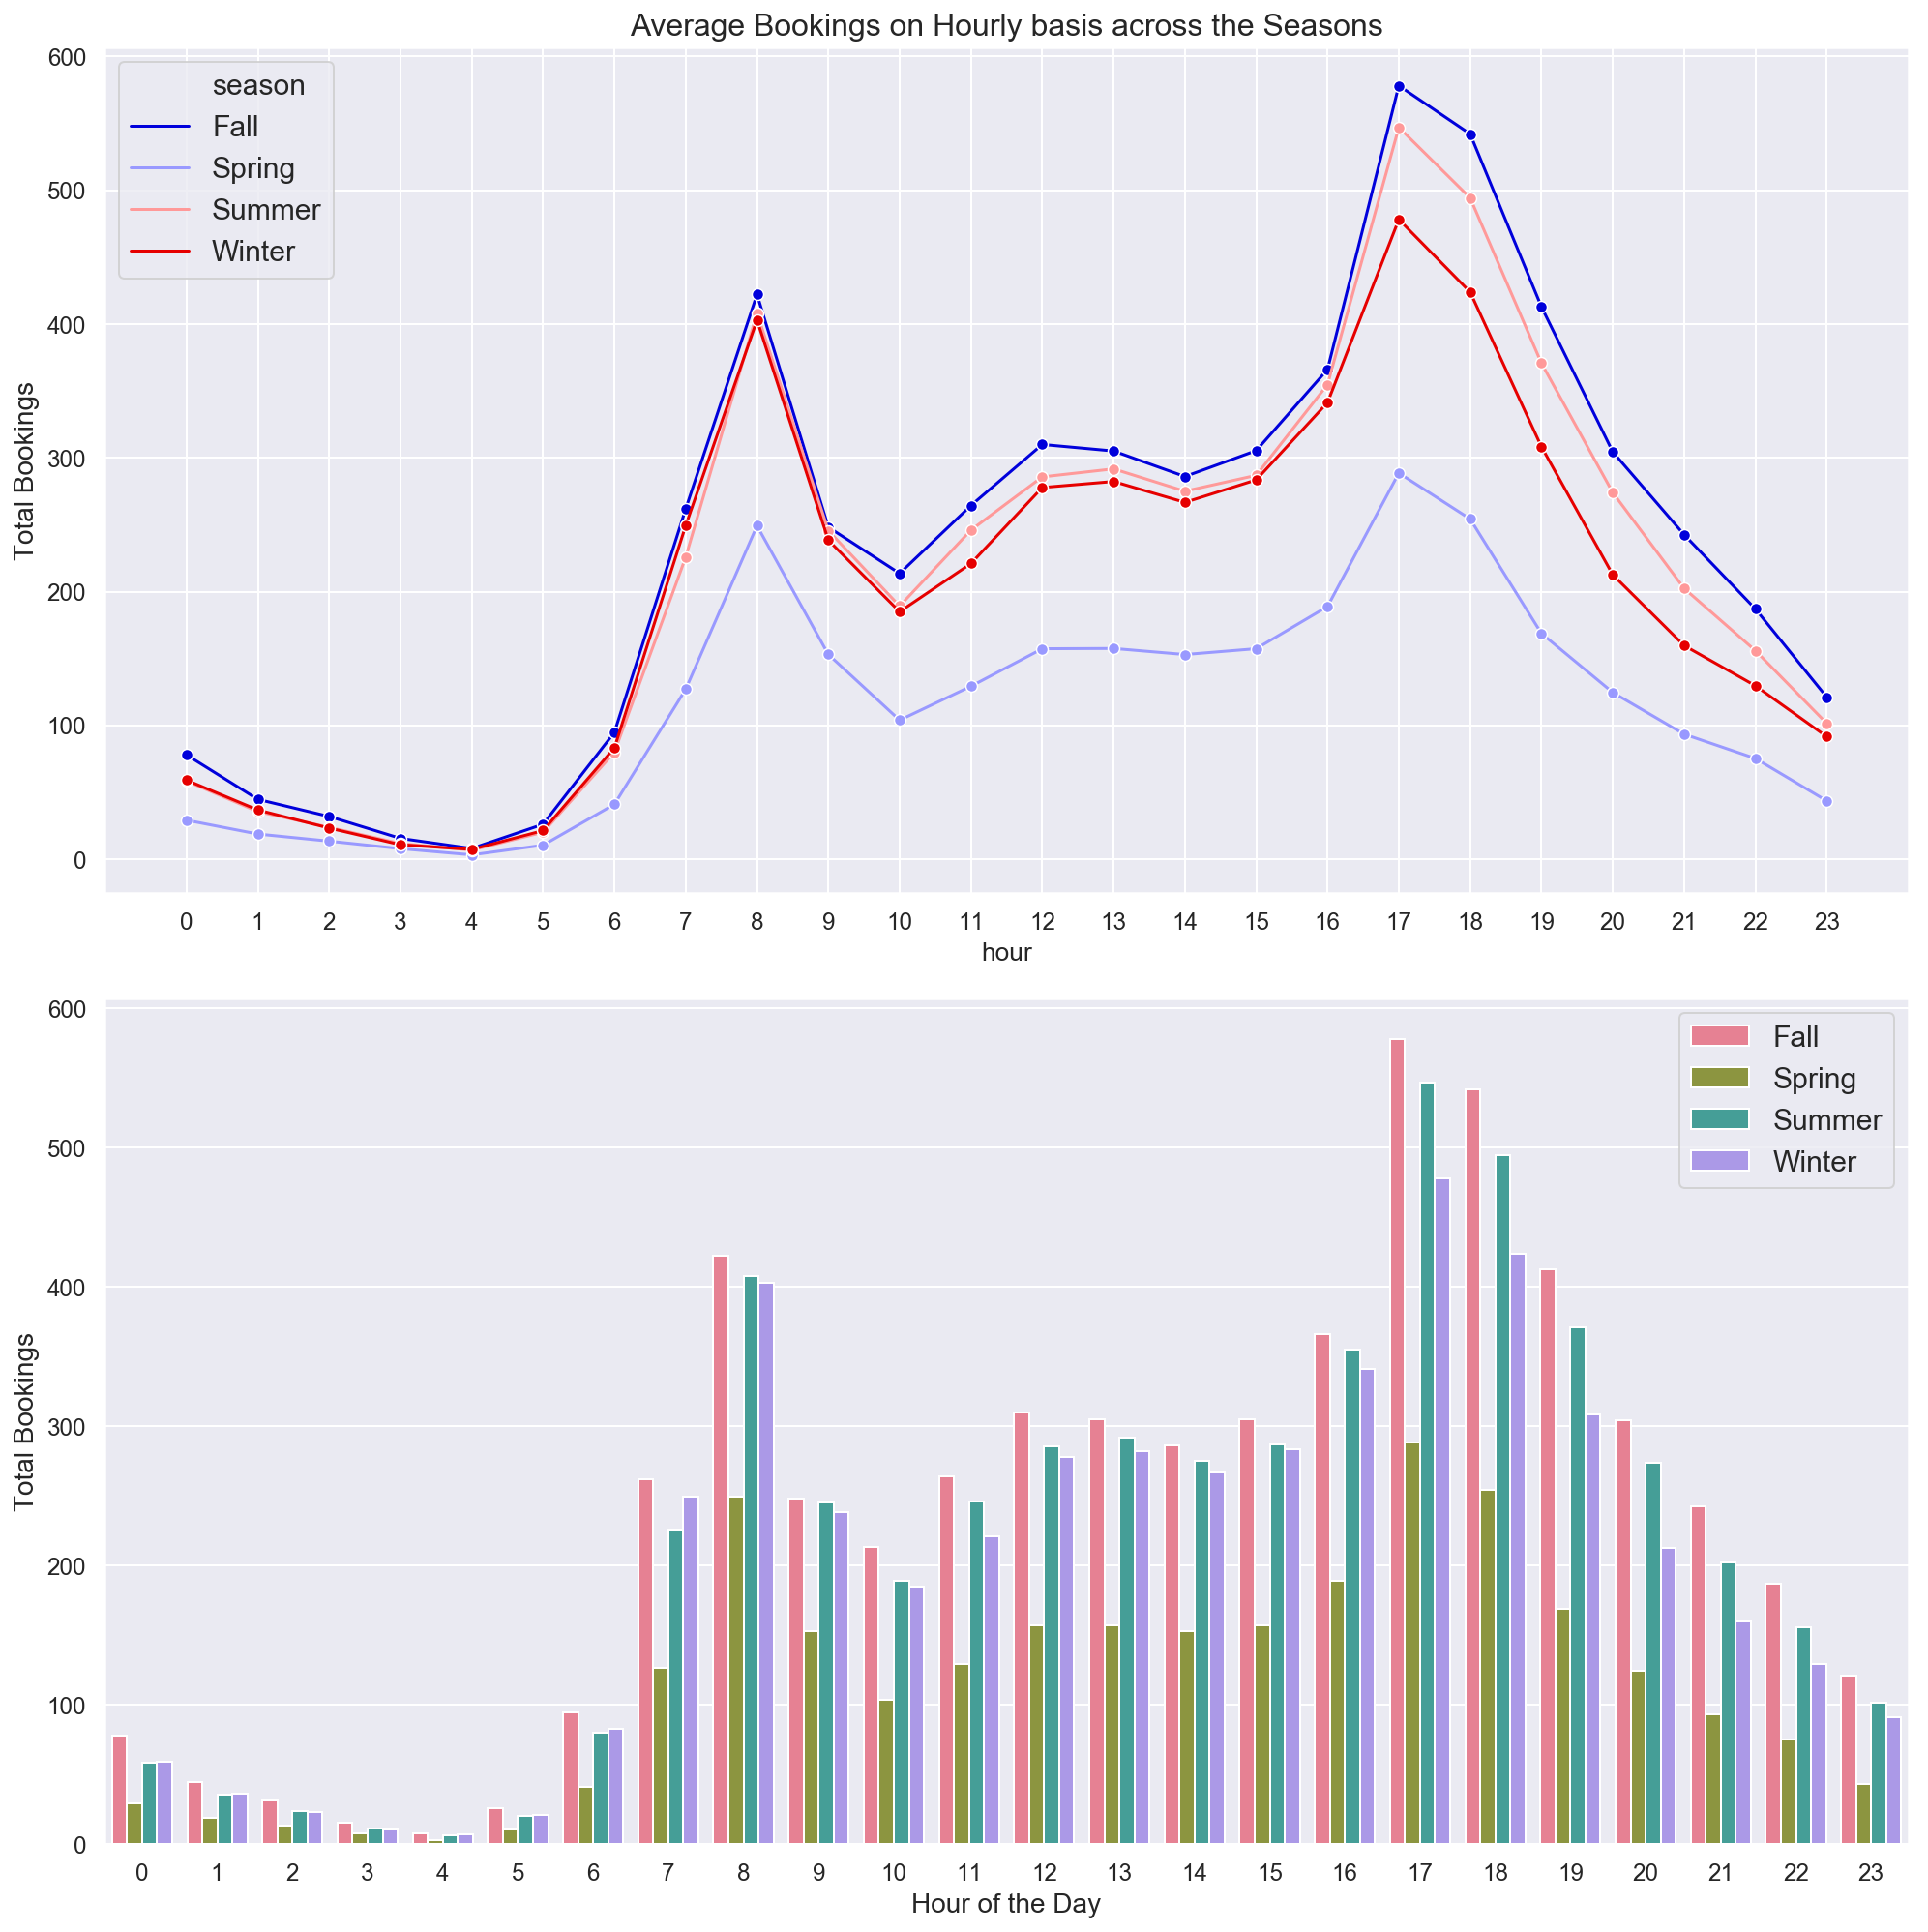

In [24]:
fig2, (ax5, ax6) = plt.subplots(nrows=2, figsize=(14, 14))

hourly = pd.DataFrame(df.groupby(['hour', 'season'], sort=True)[
                      'Total_booking'].mean()).reset_index()
# sns.set_context("poster")

sns.lineplot(x=hourly['hour'], y=hourly['Total_booking'],
             hue=hourly['season'], data=hourly, ax=ax5, palette='seismic', marker='o')
# sns.set_context("poster")

sns.barplot(x=hourly['hour'], y=hourly['Total_booking'],
            hue=hourly['season'], data=hourly, ax=ax6, palette='husl')
# sns.set_context("poster")

ax5.set_ylabel('Total Bookings', fontsize=14)
ax5.set_ylabel('Total Bookings', fontsize=14)

ax6.set_ylabel('Total Bookings', fontsize=14)
ax6.set_xlabel('Hour of the Day', fontsize=14)

ax5.legend(fontsize=15, loc=2)
ax6.legend(fontsize=15)

ax5.set_title(
    'Average Bookings on Hourly basis across the Seasons', fontsize=16)

ax5.set(xticks=range(0, 24))

plt.tight_layout()
plt.show()

#### Seasonal Insights
1. Maximum Cab booking is happening during Fall, followed by Summer.
2. There is sharp drop during the Winter period with gain during February and May again

#### Hourly Insights
1. The bookings
    - High during the morning hours (6:30 AM to 8:30)
    - Remains constant for rest of the day.
    - Peak booking happens during the evening (5 PM onwards) and then declining during the late evening.
    - This peak and slump of booking is consistently happening during working hours
2. Cab companies can reroute and focus to get customer in areas with less public transport, during the late evening.

### Hourly Bookings across the Weekday

Text(0,0.5,'Total Bookings')

Text(0.5,1,'Average Bookings on Hourly basis across the Weekday')

[[<matplotlib.axis.XTick at 0x109e82e90>,

Text(0,0.5,'Total Bookings')

Text(0.5,0,'Hour of the Day')

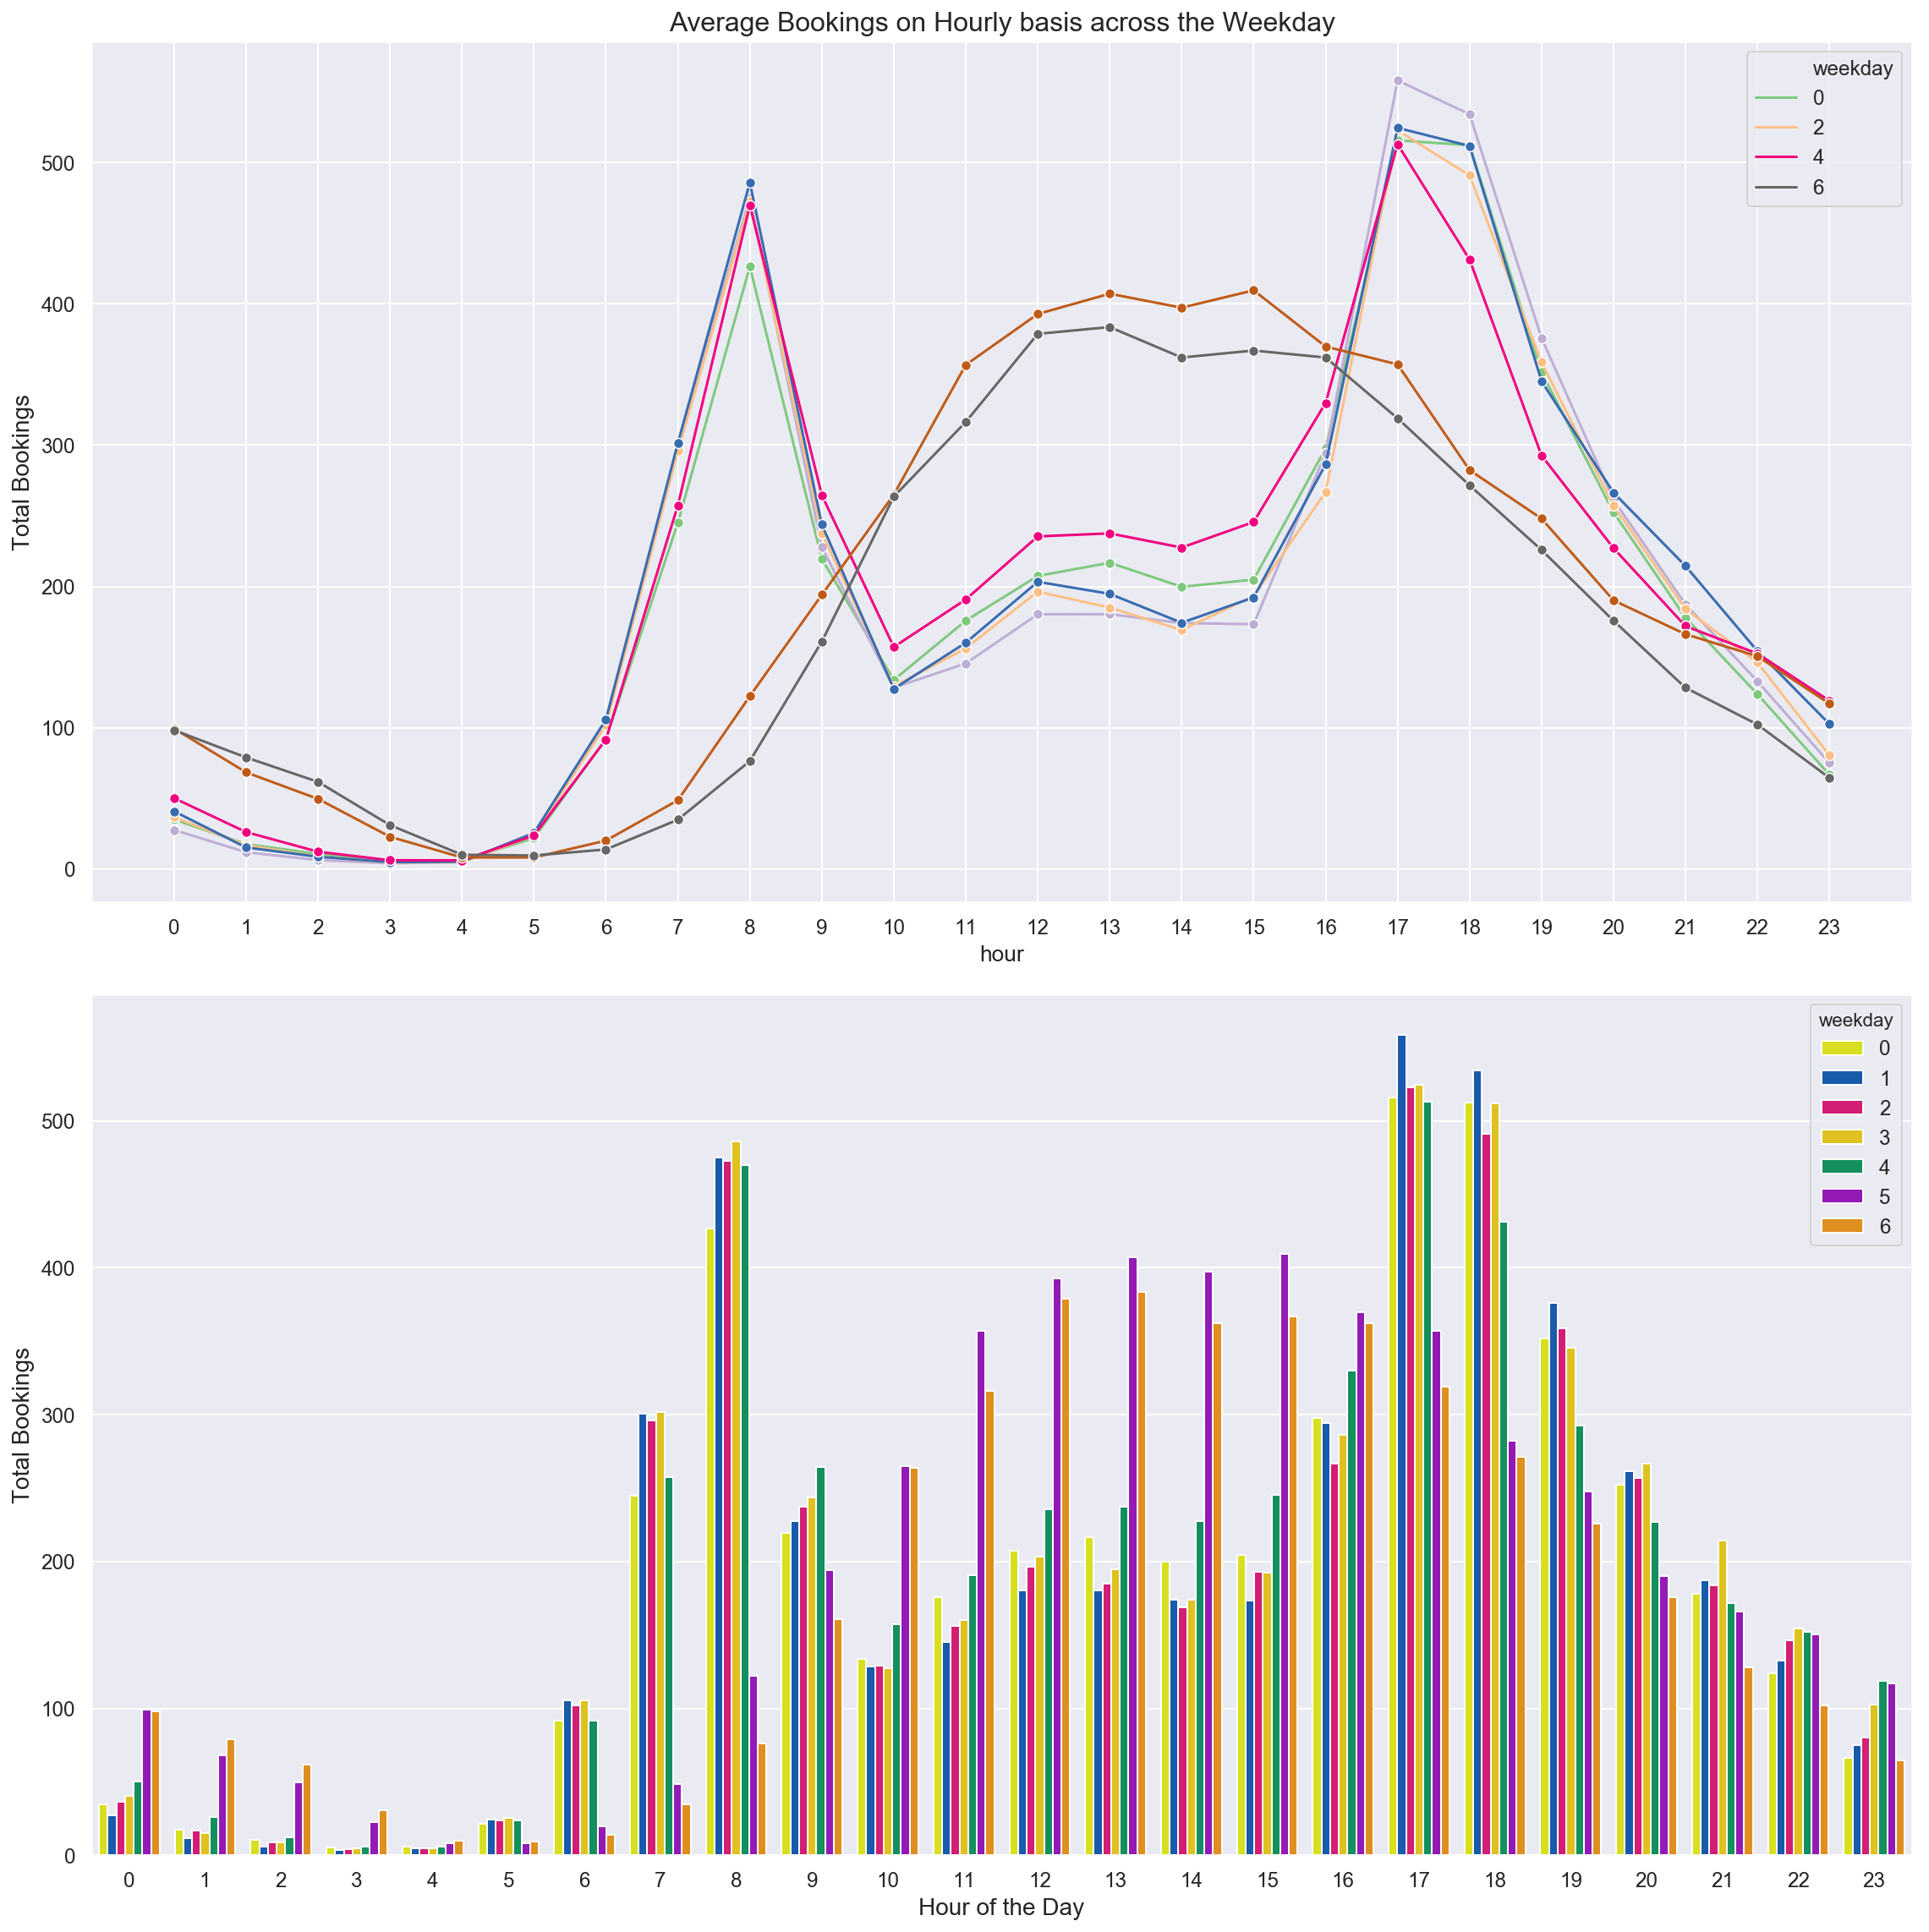

In [25]:
fig3, (ax7, ax8) = plt.subplots(nrows=2, figsize=(16, 16))

weekly = pd.DataFrame(df.groupby(['hour', 'weekday'], sort=True)[
                      'Total_booking'].mean()).reset_index()
# sns.set_context("poster")

sns.lineplot(x=weekly['hour'], y=weekly['Total_booking'],
             hue=weekly['weekday'], data=weekly, ax=ax7, palette='Accent', marker='o')
# sns.set_context("poster")

sns.barplot(x=weekly['hour'], y=weekly['Total_booking'],
            hue=weekly['weekday'], data=weekly, ax=ax8, palette='prism')
# sns.set_context("poster")

ax7.set_ylabel('Total Bookings', fontsize=14)
ax7.set_title(
    'Average Bookings on Hourly basis across the Weekday', fontsize=16)
ax7.set(xticks=range(0, 24))

ax8.set_ylabel('Total Bookings', fontsize=14)
ax8.set_xlabel('Hour of the Day', fontsize=14)

plt.tight_layout()
plt.show()

#### Insights
1. Throughout all the seasons, cab bookings are higher during the weekends than on weekdays.
2. The cab bookings peak during the start of the week i.e. Monday and Tuesday and then slumps

### Cab Rentals Distribution on Monthly Basis with respect to each Year

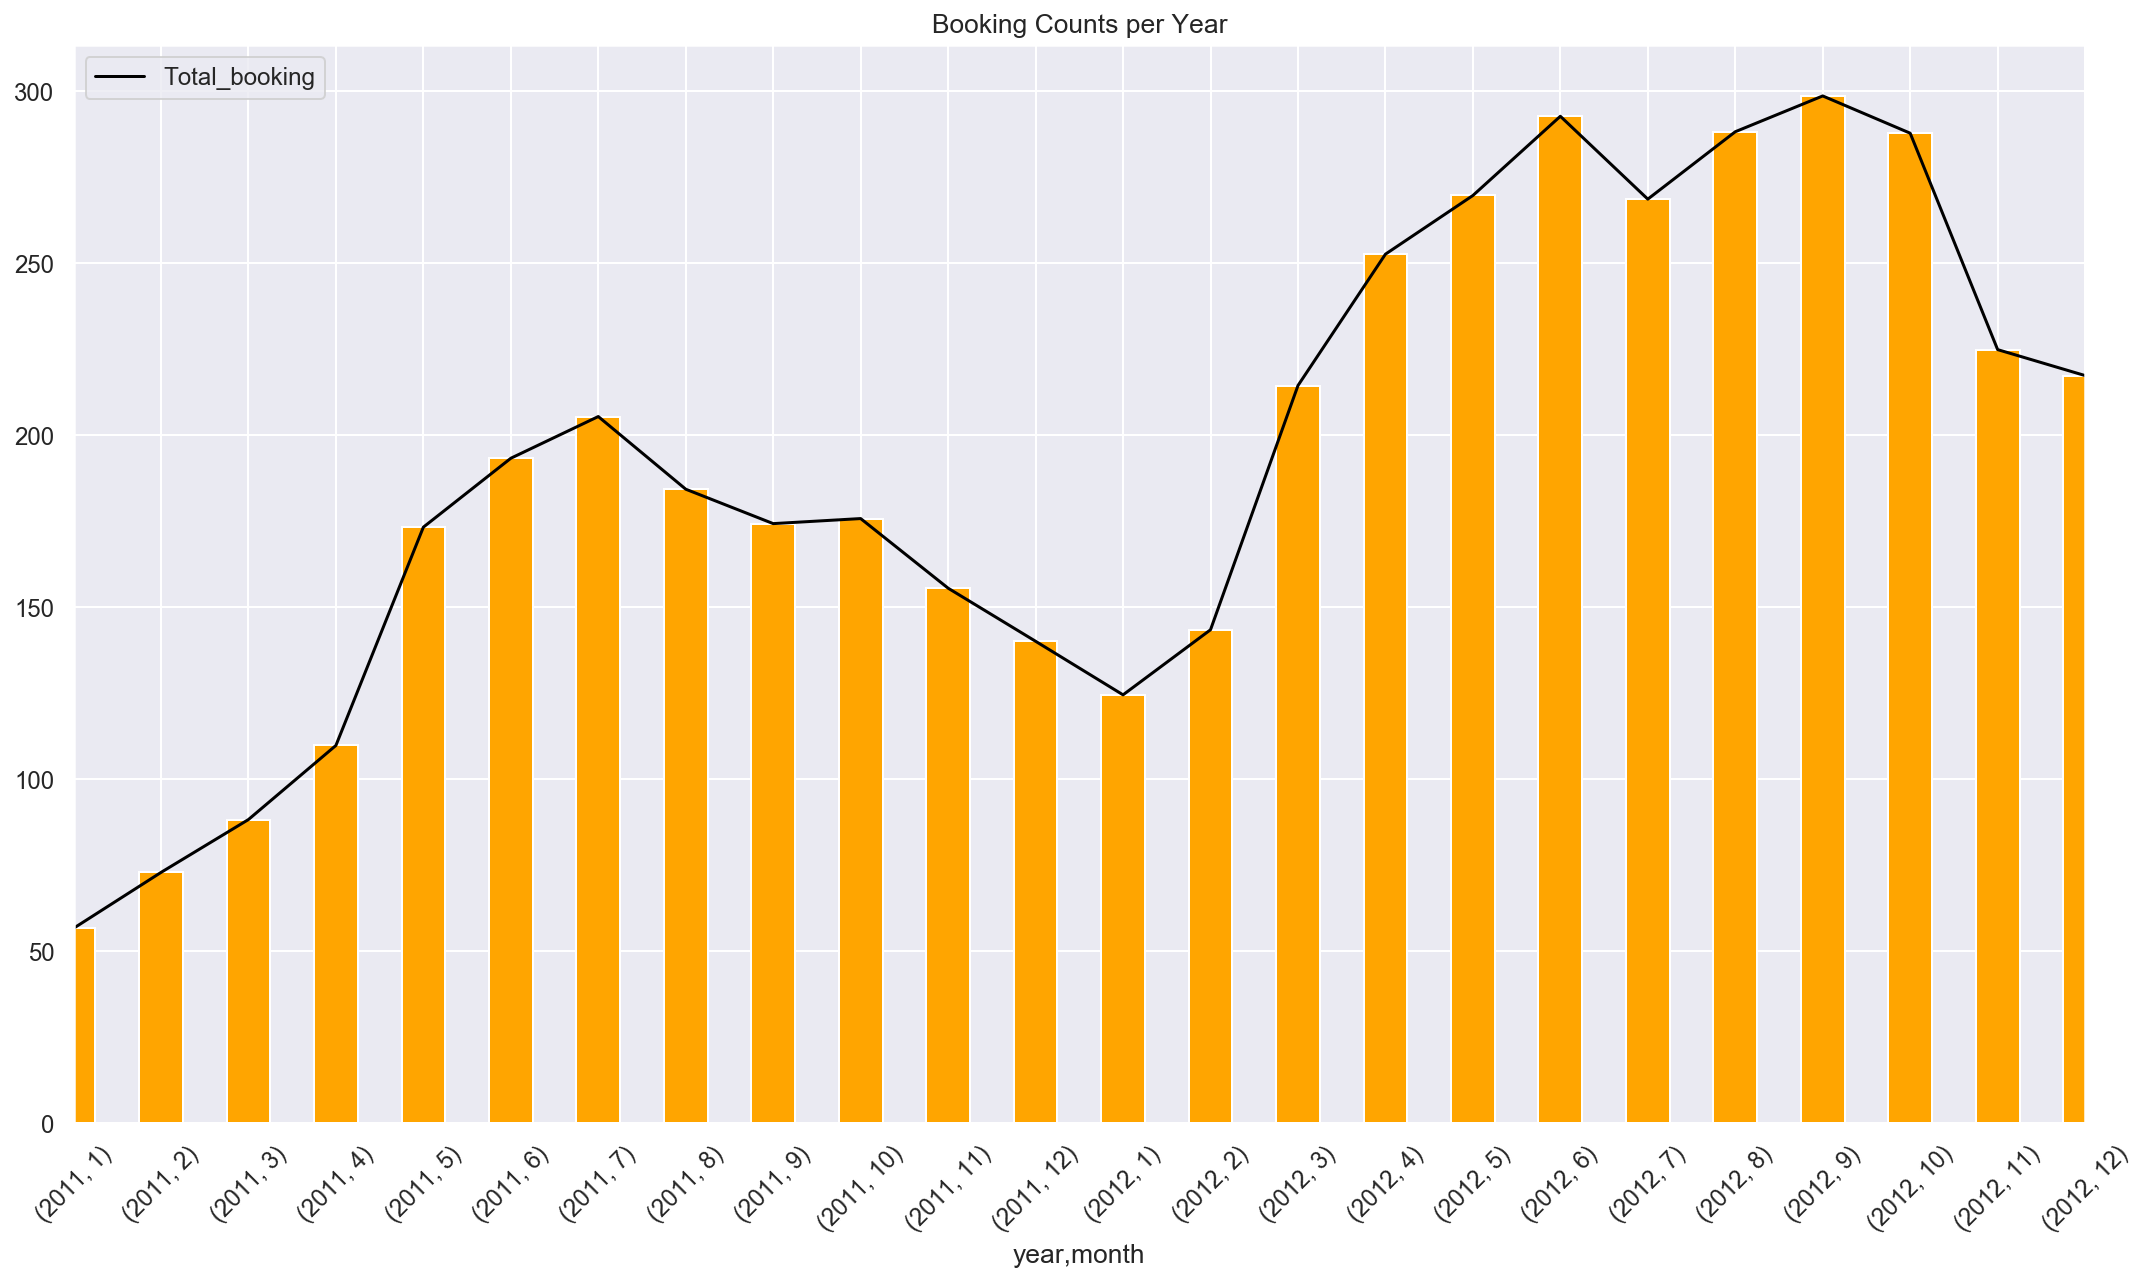

In [26]:
yearly = df.groupby(['year', 'month'])['Total_booking'].mean()

yearly.plot(kind='bar', figsize=(15, 9), fontsize=12,
            title='Booking Counts per Year', color='Orange')

yearly.plot(color='Black', rot=45, legend=True)

plt.tight_layout()
plt.show()

Text(0.5,1,'Booking Counts per Year')

<StemContainer object of 3 artists>

[None, None, None, None]

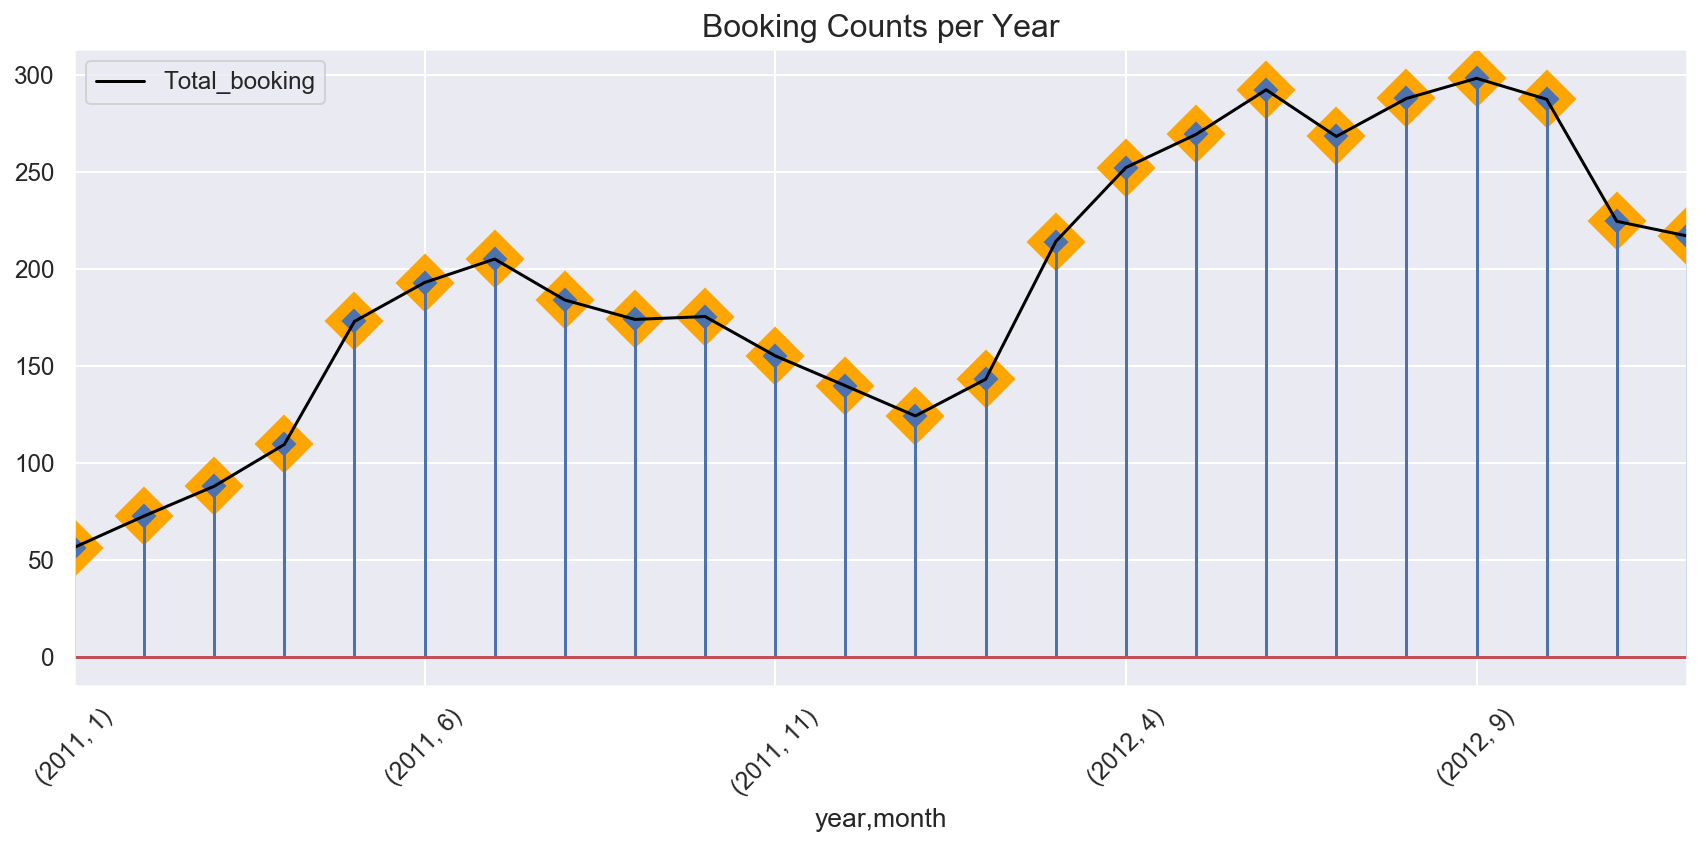

In [27]:
fig, ax_stem = plt.subplots(figsize=(12, 6))
ax_stem.set_title('Booking Counts per Year', fontsize=16)

yearly = df.groupby(['year', 'month'])['Total_booking'].mean()

# plot with no marker
plt.stem(yearly, markerfmt=' ')

# change color and shape and size and edges
(markers, stemlines, baseline) = plt.stem(yearly)

plt.setp(markers, marker='D', markersize=15,
         markeredgecolor="orange", markeredgewidth=6)

yearly.plot(color='Black', rot=45, legend=True)

plt.tight_layout()
plt.show()

#### Insights
1. The trend for cab booking for the year 2011 is similar to 2012 but 2012 has significantly higher number of cab booking.
2. For the months of June, August, September, and October, 2012 has more booking than 2011.
3. Focus should be there to increase the cab booking during the first few months of the year (both 2011 and 2012)

### Relationship between Cab Booking and Seasonal Weather

Text(0.5,0,'Seasons')

Text(0,0.5,'Bookings Counts')

Text(0.5,0,'Weather')

Text(0,0.5,'Bookings Counts')

Text(0.5,1,'Bookings in Each Season')

Text(0.5,1,'Bookings During Different Weather Conditions')

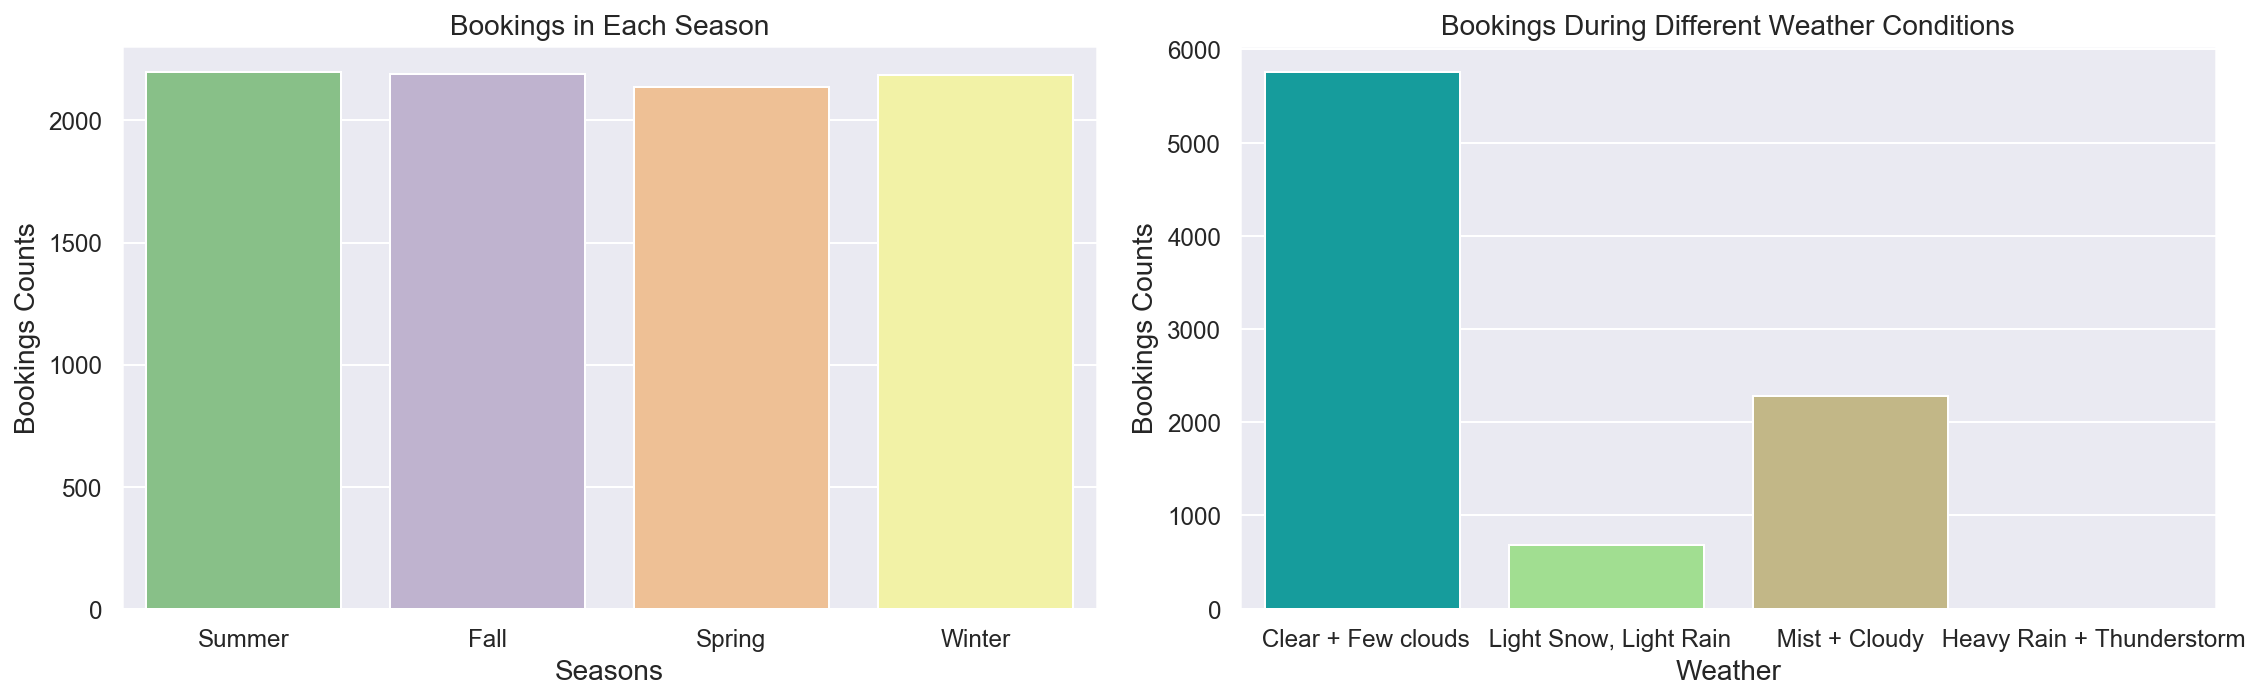

In [28]:
fig4, (ax9, ax10) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

sns.countplot(df.season, palette='Accent', ax=ax9)
sns.countplot(df.weather, palette='terrain', ax=ax10)

ax9.set_xlabel('Seasons', fontsize=14)
ax9.set_ylabel('Bookings Counts', fontsize=14)
ax10.set_xlabel('Weather', fontsize=14)
ax10.set_ylabel('Bookings Counts', fontsize=14)

ax9.set_title('Bookings in Each Season', fontsize=14)
ax10.set_title('Bookings During Different Weather Conditions', fontsize=14)

plt.tight_layout()
plt.show()

#### Insights
1. Seasons have negligible effect on number of bookings, except that we notice some decline during the Spring.
2. As for the different weather conditions, we notice quite contrast in the booking
    - Clear Weather with light cloud --> Most conducive for the business.
    - Cloudy and misty days --> There is a decline during this weather pattern.
    - Light Snow or Rain --> Very low cab booking count.
    - Heavy Rain and Thunderstorm - Negligible to no booking.

## Correlation Analysis

### Correaltion between Total Cab Booking and All the variable in the Dataset

In [29]:
corr_status_all = df[df.columns[0:]].corr()['Total_booking']
corr_status_all

year             0.266228
month            0.170355
day              0.022549
hour             0.399947
weekday         -0.005554
holiday         -0.004391
workingday       0.012285
temp             0.397456
atemp            0.392754
humidity        -0.307982
windspeed        0.092090
Total_booking    1.000000
Name: Total_booking, dtype: float64

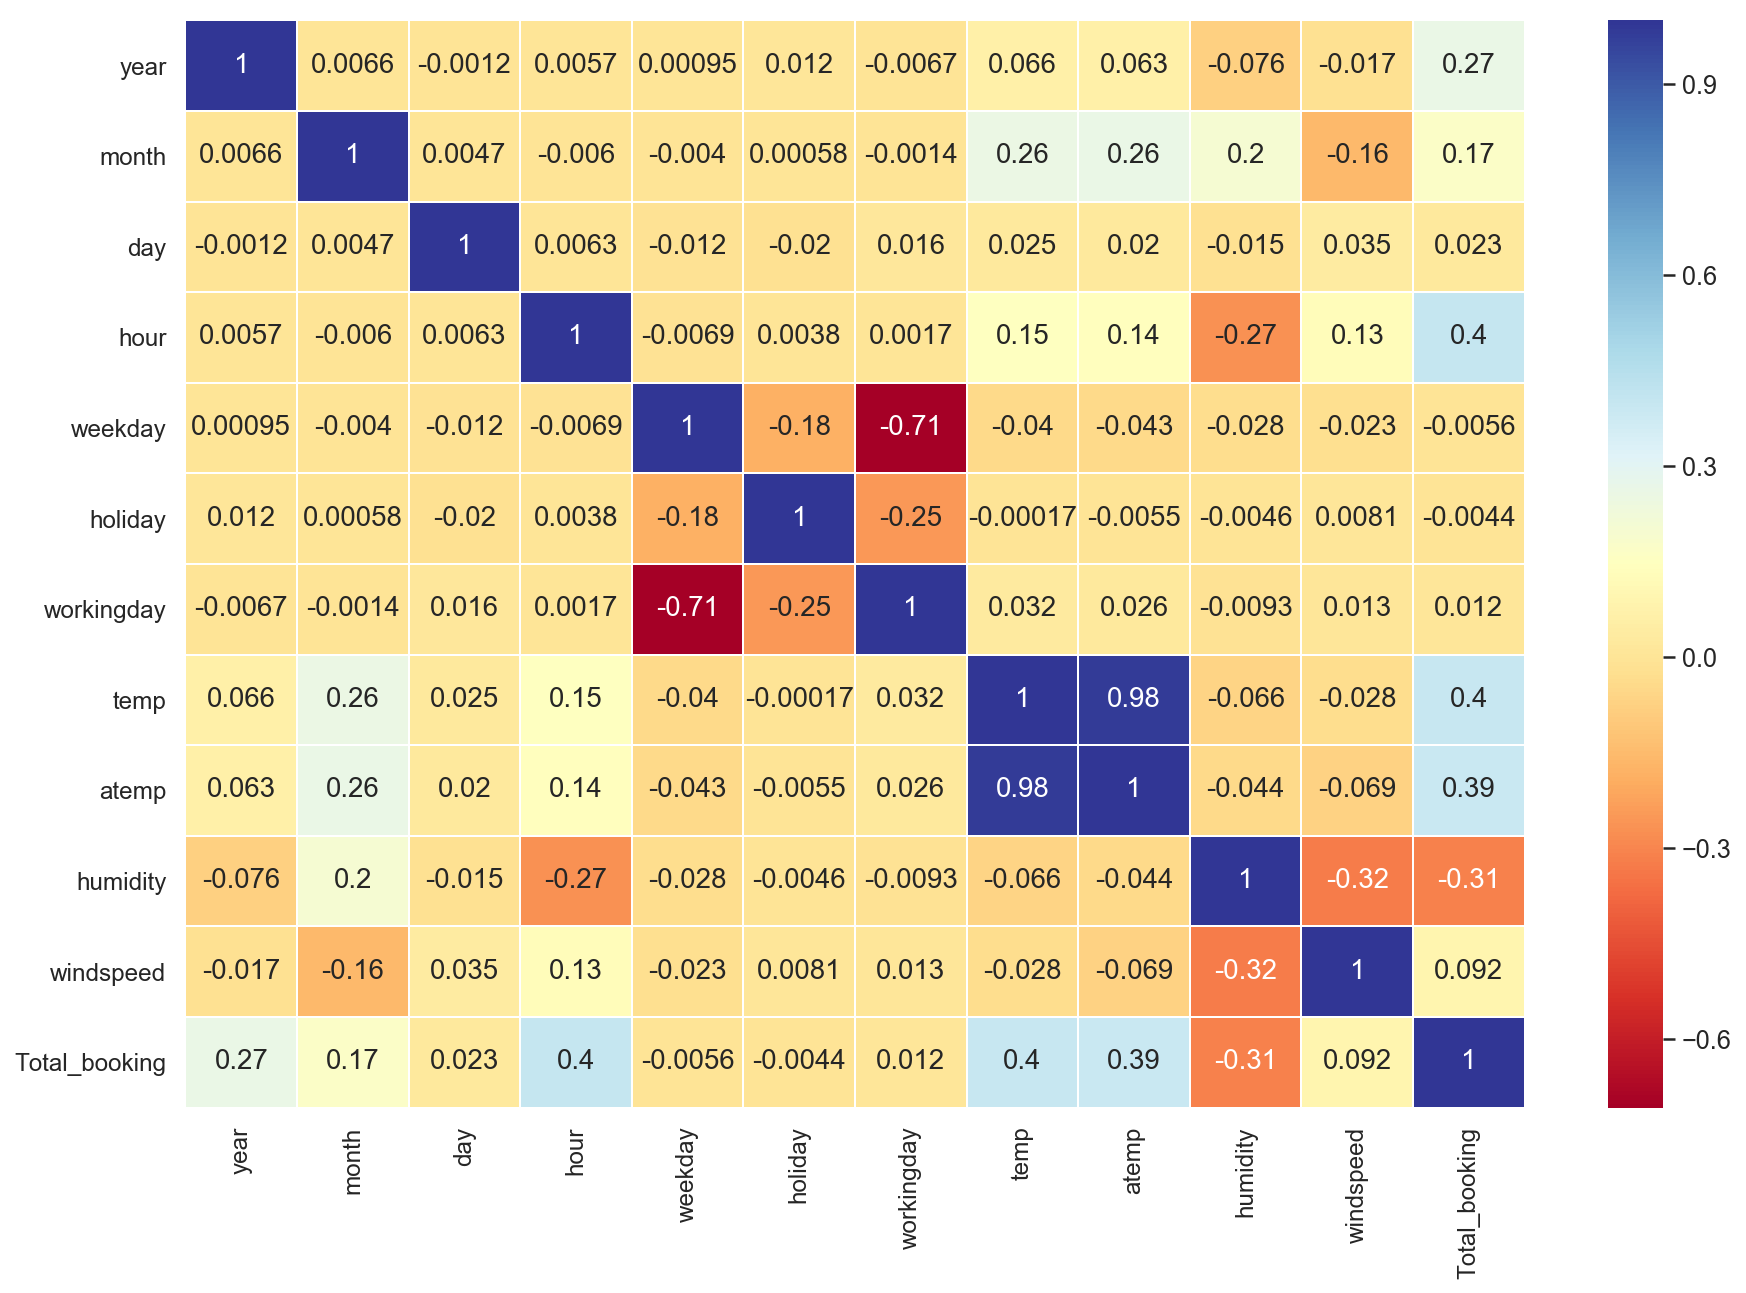

In [30]:
var_corr = df.corr()
fig, ax101 = plt.subplots(figsize=(15, 10))

sns.set(font_scale=1.15)
sns.heatmap(df.corr(), xticklabels=var_corr.columns,
            yticklabels=var_corr.columns, annot=True, linewidths=.5, ax=ax101, cmap='RdYlBu')

#### Insights
1. "temp" and "atemp" variables are highly collinear. "atemp" being apposite to the customers, will be used for the prediction.
2. "weekday" and "workday" are inversly propertional to each other.
3. "Total_booking" is inversly dependent on "humidity" of the day.
4. Bookings are happening on working day, holiday and and rest days of the week.

### Dependencies between Weather and Cab Booking

In [31]:
corr_status_wx = df[df.columns[4:]].corr()['Total_booking']
corr_status_wx

weekday         -0.005554
holiday         -0.004391
workingday       0.012285
temp             0.397456
atemp            0.392754
humidity        -0.307982
windspeed        0.092090
Total_booking    1.000000
Name: Total_booking, dtype: float64

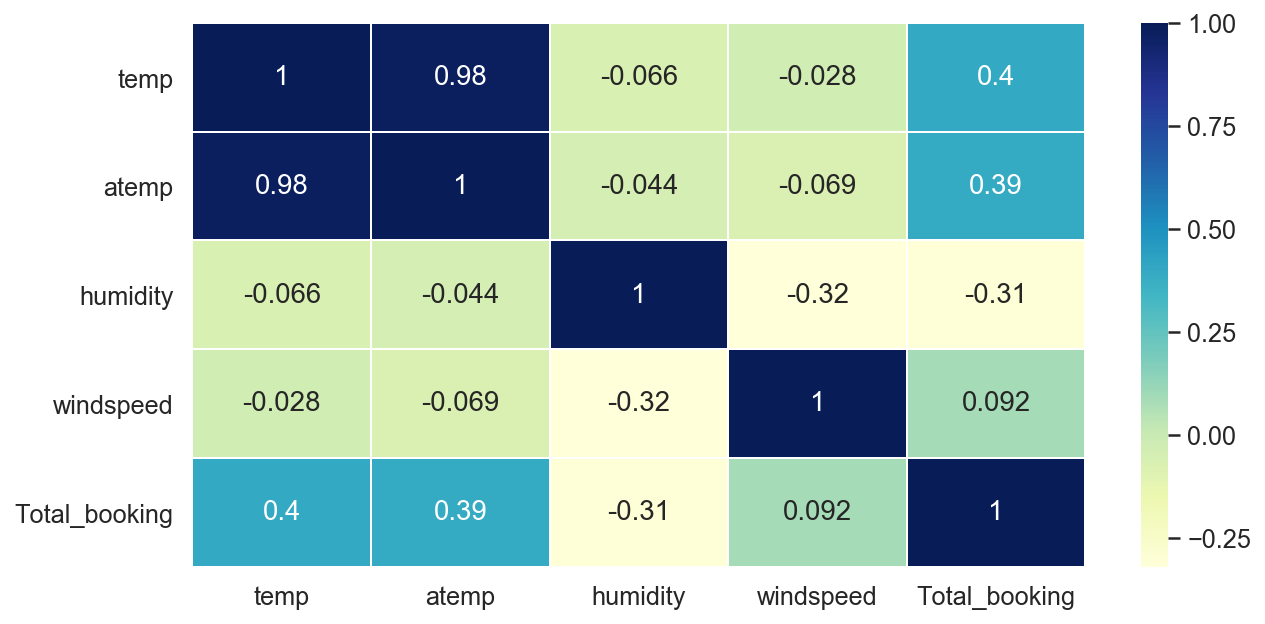

In [32]:
var_param = df[['temp', 'atemp', 'humidity', 'windspeed', 'Total_booking']]
fig, ax102 = plt.subplots(figsize=(10, 5))

sns.set(font_scale=1.15)
sns.heatmap(var_param.corr(), xticklabels=var_param.columns,
            yticklabels=var_param.columns, annot=True, linewidths=.5, ax=ax102, cmap='YlGnBu')

#### Insights
1. "temp" and "atemp" variables are highly collinear. "atemp" being apposite to the customers, will be used for the prediction.
2. Bookings registered during hot days are higher than humid ones.

### Relationship between Weather and Cab Bookings

Text(0.5,1,'Feels Like Temperature vs Cab Booking')

[Text(0,0.5,'Total_booking'), Text(0.5,0,'ATemp')]

Text(0.5,1,'Windspeed vs Cab Booking')

[Text(0,0.5,'Total_booking'), Text(0.5,0,'Windspeed')]

Text(0.5,1,'Humidity vs Cab Booking')

[Text(0,0.5,'Total_booking'), Text(0.5,0,'Humidity')]

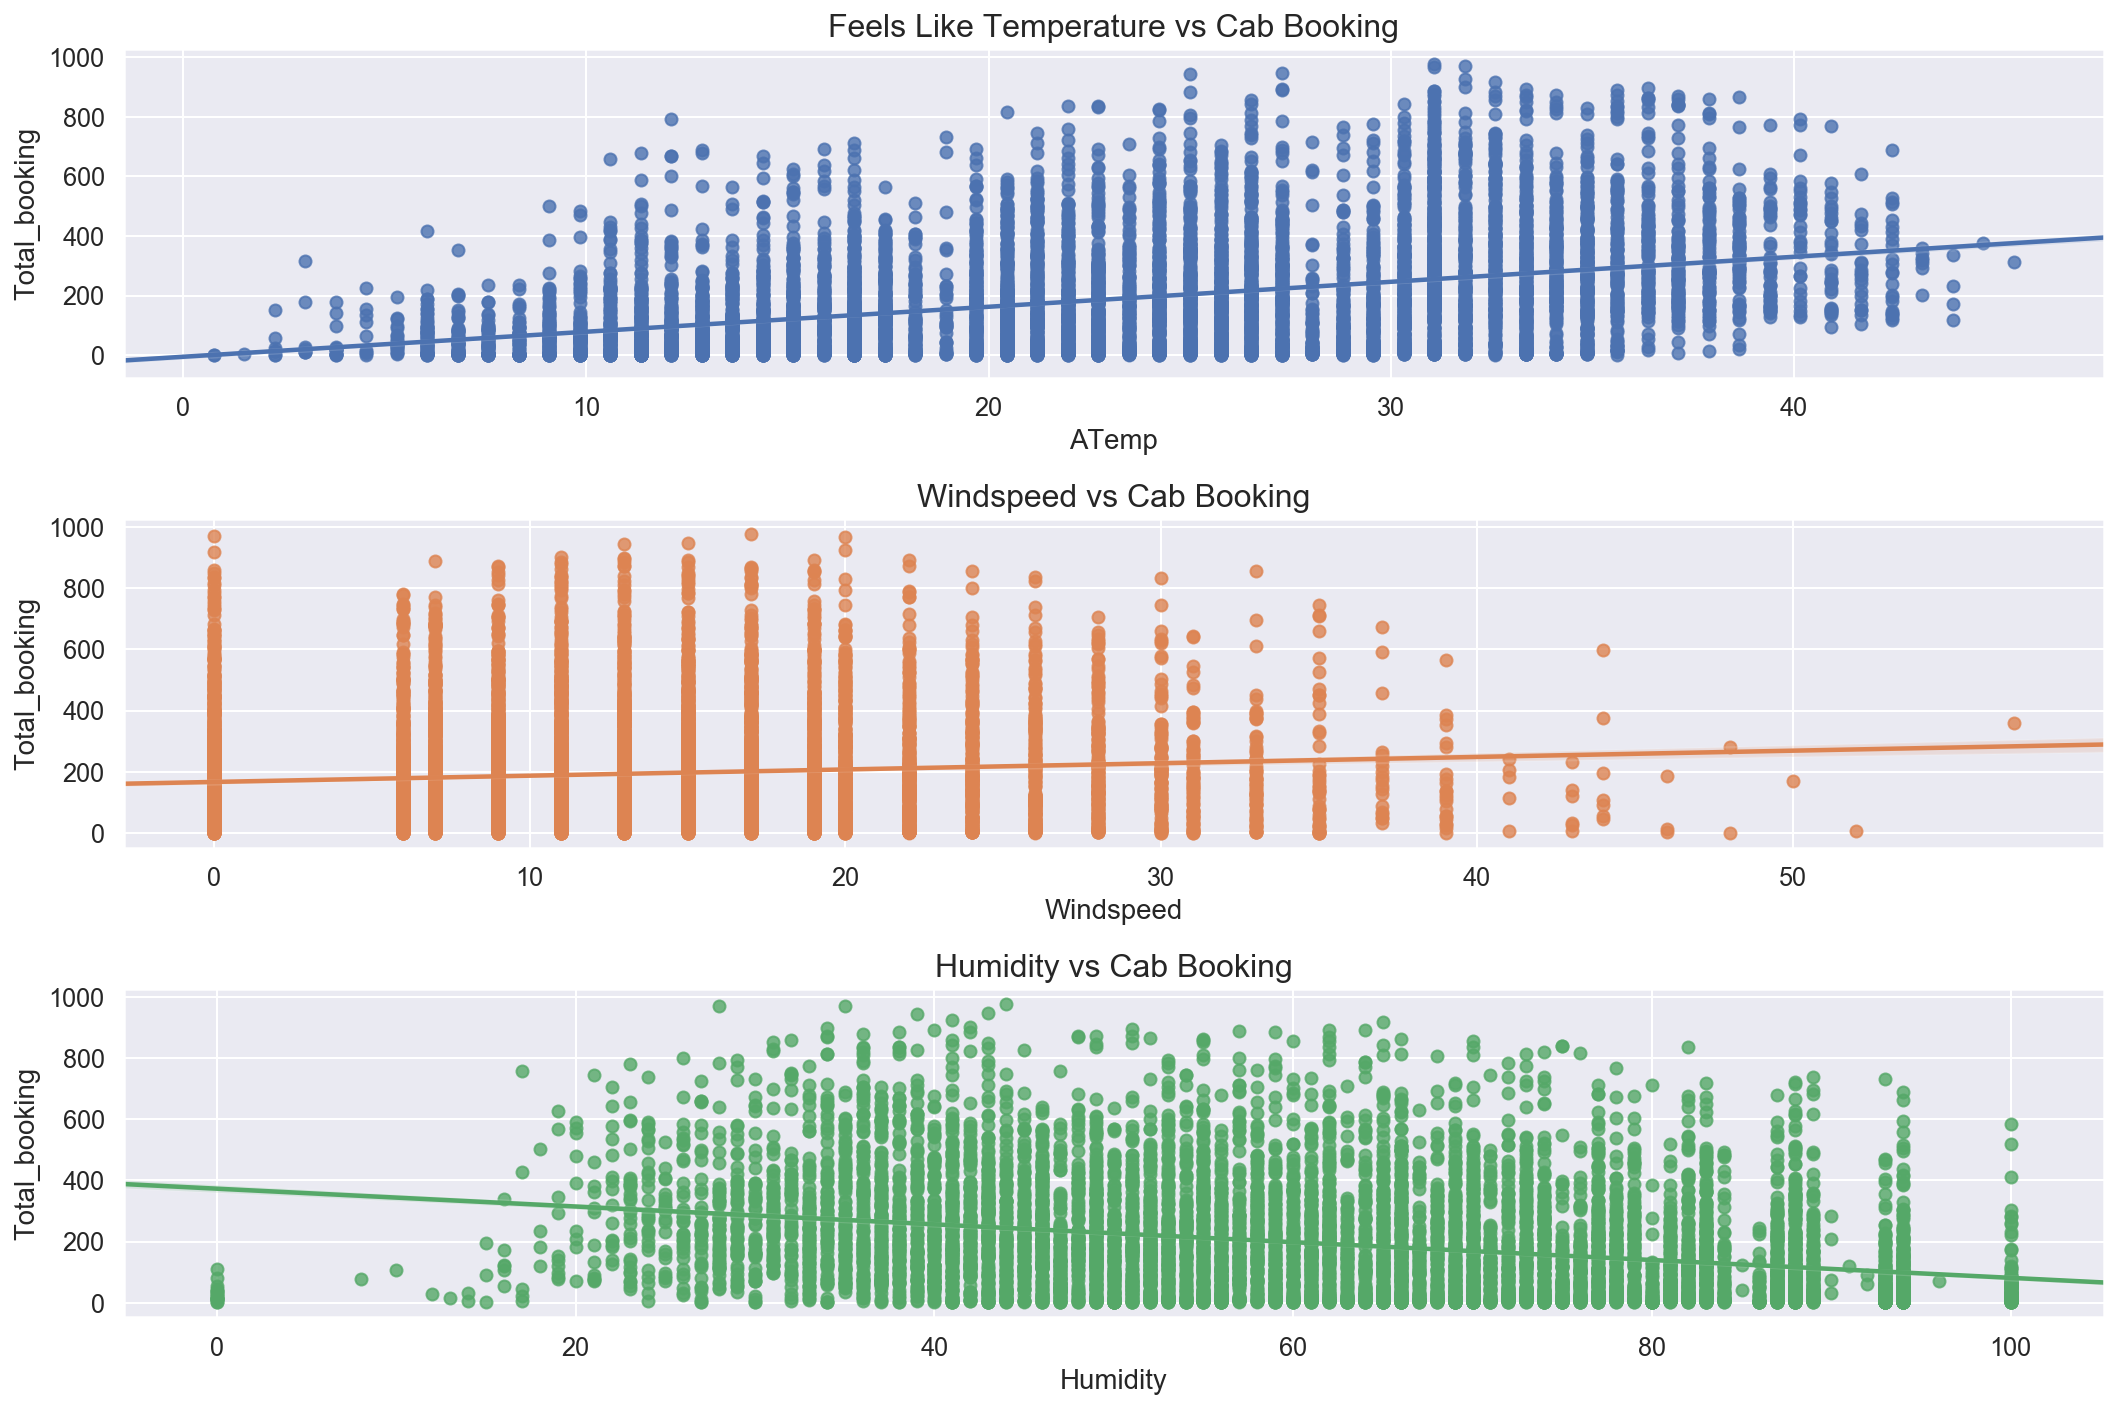

In [33]:
fig, (ax11, ax12, ax13) = plt.subplots(nrows=3, figsize=(15, 10))

sns.regplot(x='atemp', y='Total_booking', data=df, ax=ax11)
sns.regplot(x='windspeed', y='Total_booking', data=df, ax=ax12)
sns.regplot(x='humidity', y='Total_booking', data=df, ax=ax13)

ax11.set_title('Feels Like Temperature vs Cab Booking', fontsize=16)
ax11.set(xlabel='ATemp', ylabel='Total_booking')

ax12.set_title('Windspeed vs Cab Booking', fontsize=16)
ax12.set(xlabel='Windspeed', ylabel='Total_booking')

ax13.set_title('Humidity vs Cab Booking', fontsize=16)
ax13.set(xlabel='Humidity', ylabel='Total_booking')

plt.tight_layout()
plt.show()

#### Insights
1. None of the parameters, 'atemp', 'windspeed', 'humidity' is impacting Cab Bookings.
2. Data points from regression line, are very widely spread hence predictions using these will yeild low accuracies.

## Outlier Analysis

[Text(0,0.5,'Total_booking'), Text(0.5,1,'Total Booking')]

[Text(0,0.5,'Season'), Text(0.5,1,'Total Booking across Seasons')]

[Text(0,0.5,'Hour of the Day'), Text(0.5,1,'Total Booking across Hours')]

[Text(0,0.5,'Working Day'), Text(0.5,1,'Total Booking across Working Day')]

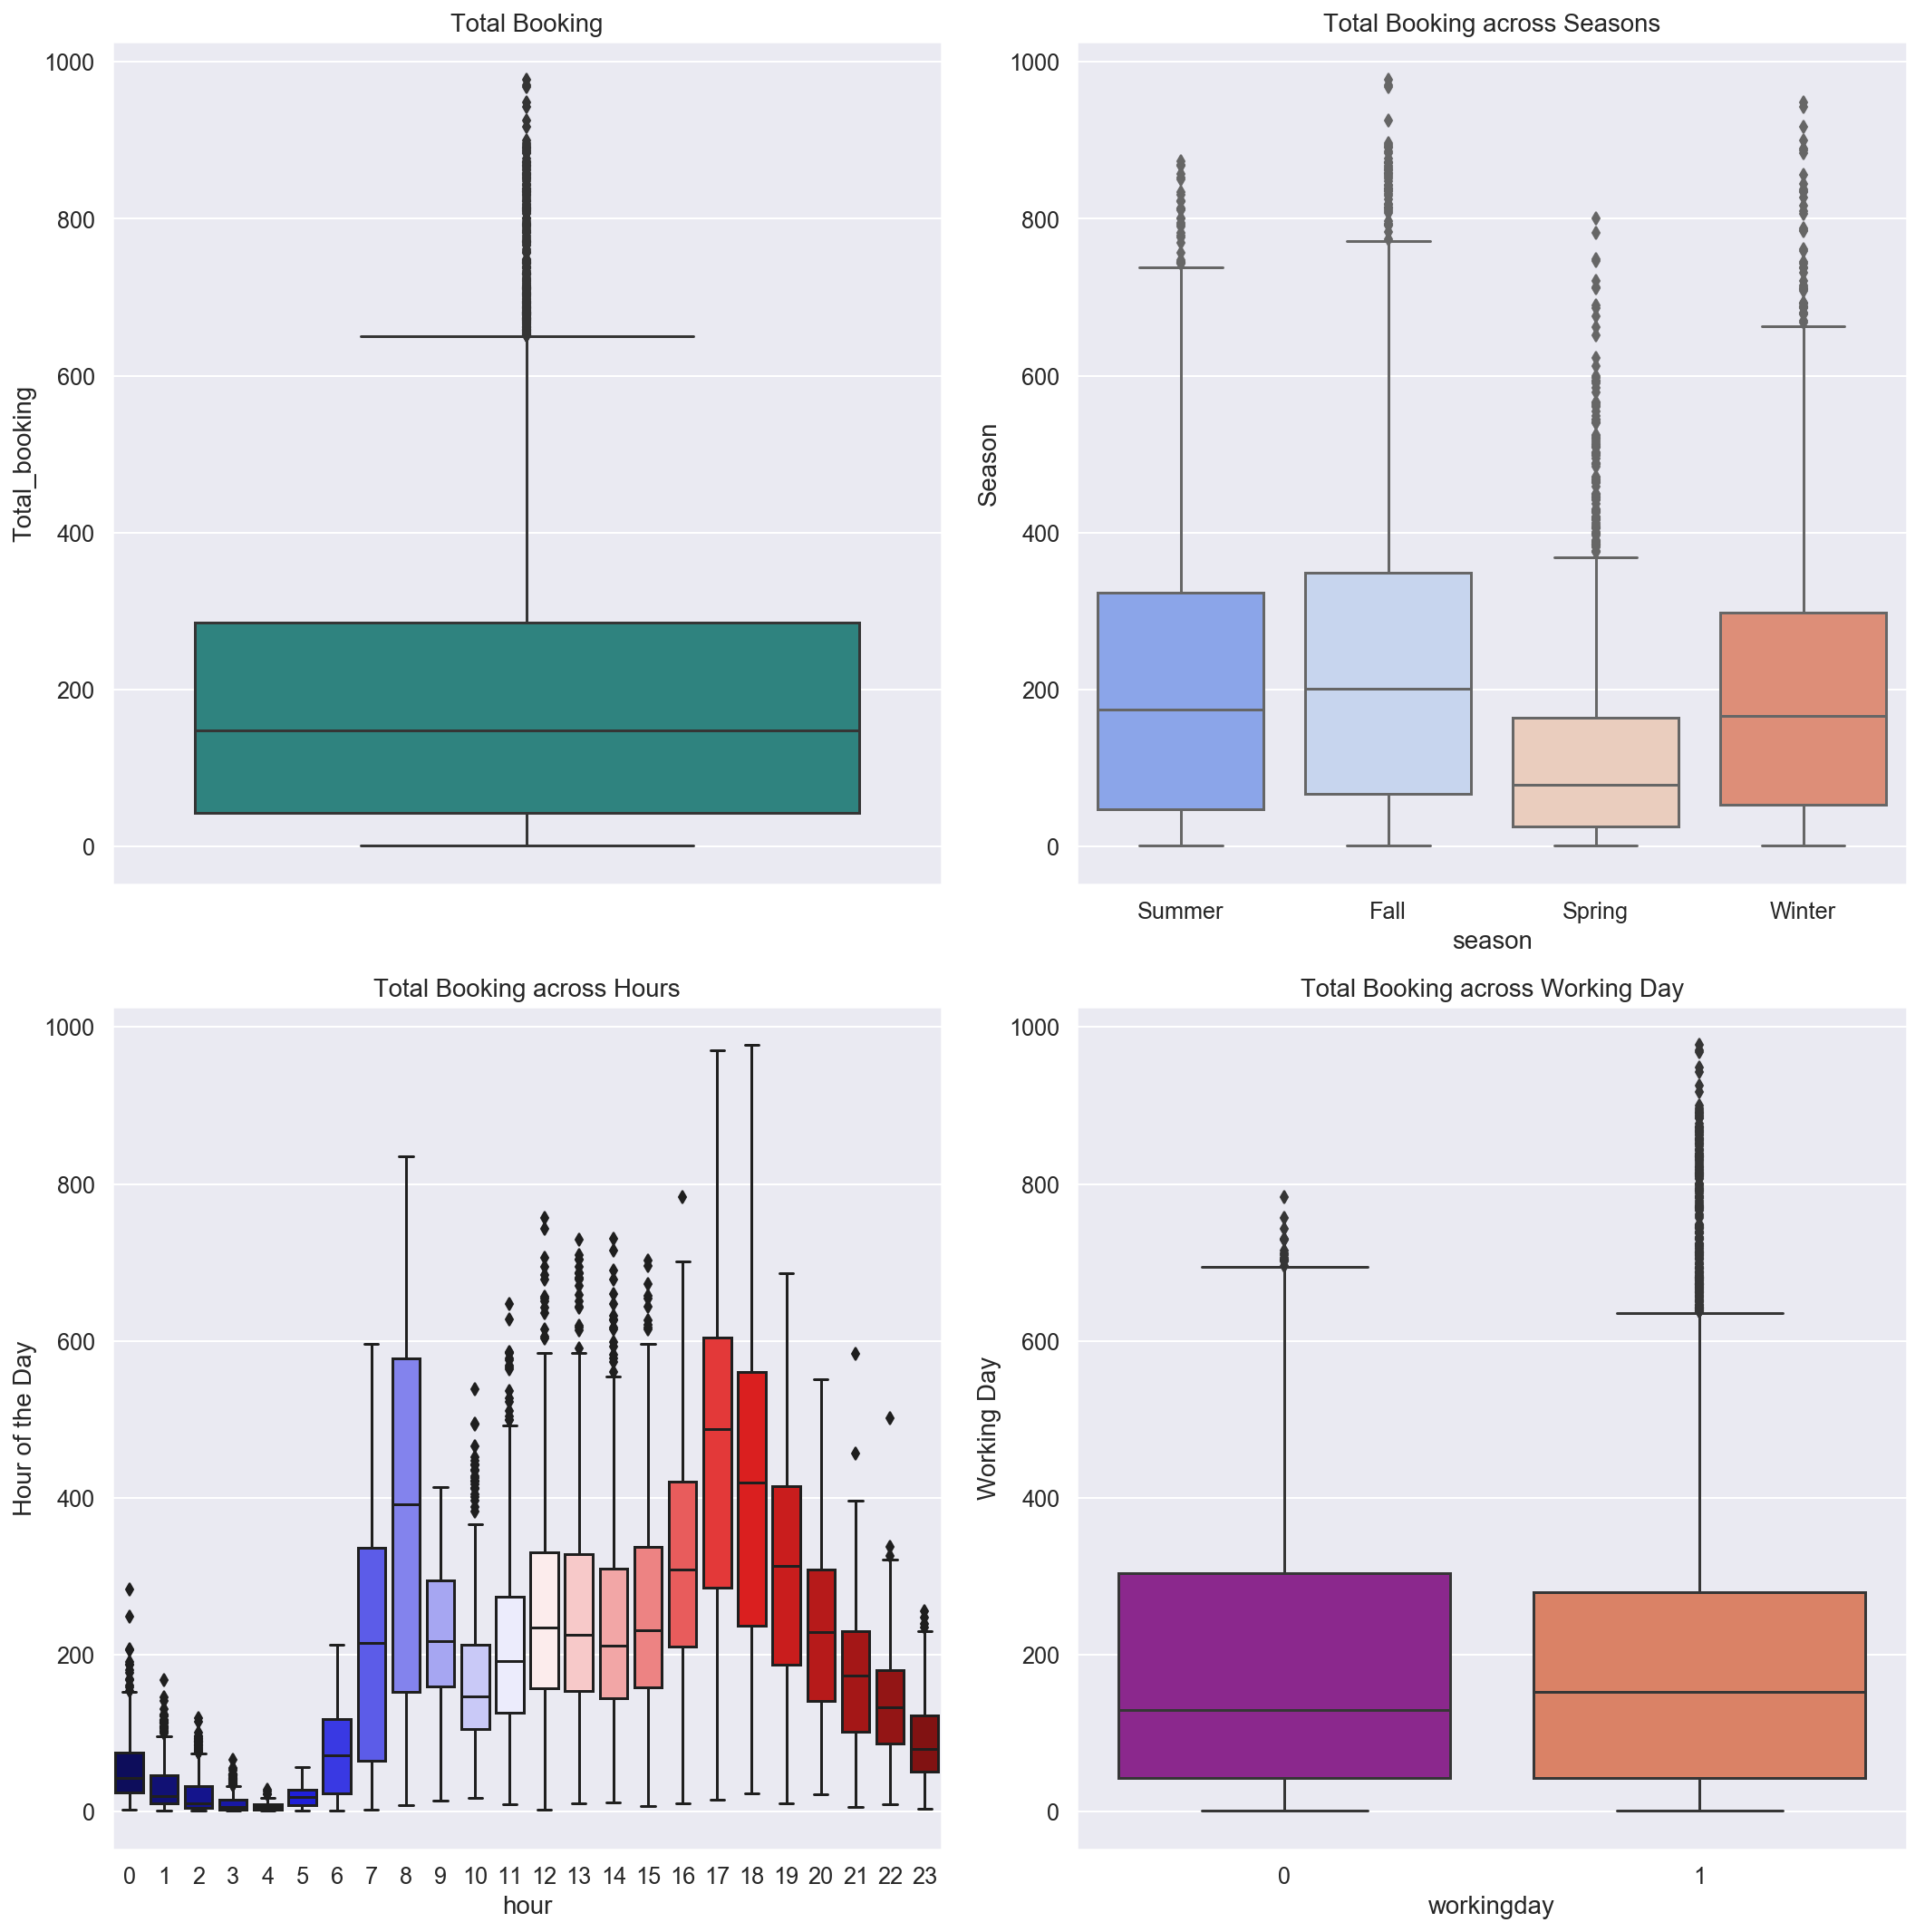

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

sns.boxplot(data=df, y='Total_booking', orient='v',
            ax=axes[0][0], palette='viridis')

sns.boxplot(data=df, y='Total_booking', x='season',
            orient='v', ax=axes[0][1], palette='coolwarm')

sns.boxplot(data=df, y='Total_booking', x='hour',
            orient='v', ax=axes[1][0], palette='seismic')

sns.boxplot(data=df, y='Total_booking', x='workingday',
            orient='v', ax=axes[1][1], palette='plasma')

axes[0][0].set(ylabel='Total_booking', title='Total Booking')
axes[0][1].set(ylabel='Season', title='Total Booking across Seasons')
axes[1][0].set(ylabel='Hour of the Day', title='Total Booking across Hours')
axes[1][1].set(ylabel='Working Day', title='Total Booking across Working Day')

plt.tight_layout()
plt.show()

#### Insights
1. Hour of the Day (checking the Mean value)
    - Highest between 5 to 6 PM
    - High between 7 AM to 9 AM
    - Inference - Cab bookings are very frequent during Office and School hours.
2. Day of the Week
    - Outlier data is higher during the Weekdays.
    - Inference - People are booking cabs beyond the regular hours. This can be due to visits to relatives, running some errands and so on.
3. Season
    - Spring season has lowest count of the cab booking but the outlier data present is highest
    - Inference - The cab bookings are happening more becuase of trips or unscheduled visits; but its sporadic in nature.

### Outlier Removal

In [35]:
dfwout = df[np.abs(df['Total_booking'] - df['Total_booking'].mean())
            <= (1.5 * df['Total_booking'].std())]

dvwout = dv[np.abs(dv['Total_booking'] - dv['Total_booking'].mean())
            <= (1.5 * dv['Total_booking'].std())]

In [36]:
print(f'Shape with Outliers: {df.shape}')
print(f'Shape with Outliers: {dfwout.shape}')

Shape with Outliers: (8708, 14)
Shape with Outliers: (7909, 14)


In [37]:
df1 = dfwout.copy()

In [38]:
print(f'Shape without Outliers: {dv.shape}')
print(f'Shape without Outliers: {dvwout.shape}')

Shape without Outliers: (2178, 14)
Shape without Outliers: (1969, 14)


In [39]:
dv1 = dvwout.copy()

[Text(0,0.5,'Total_booking'), Text(0.5,1,'Total Booking')]

[Text(0,0.5,'Season'), Text(0.5,1,'Total Booking across Seasons')]

[Text(0,0.5,'Hour of the Day'), Text(0.5,1,'Total Booking across Hours')]

[Text(0,0.5,'Working Day'), Text(0.5,1,'Total Booking across Working Day')]

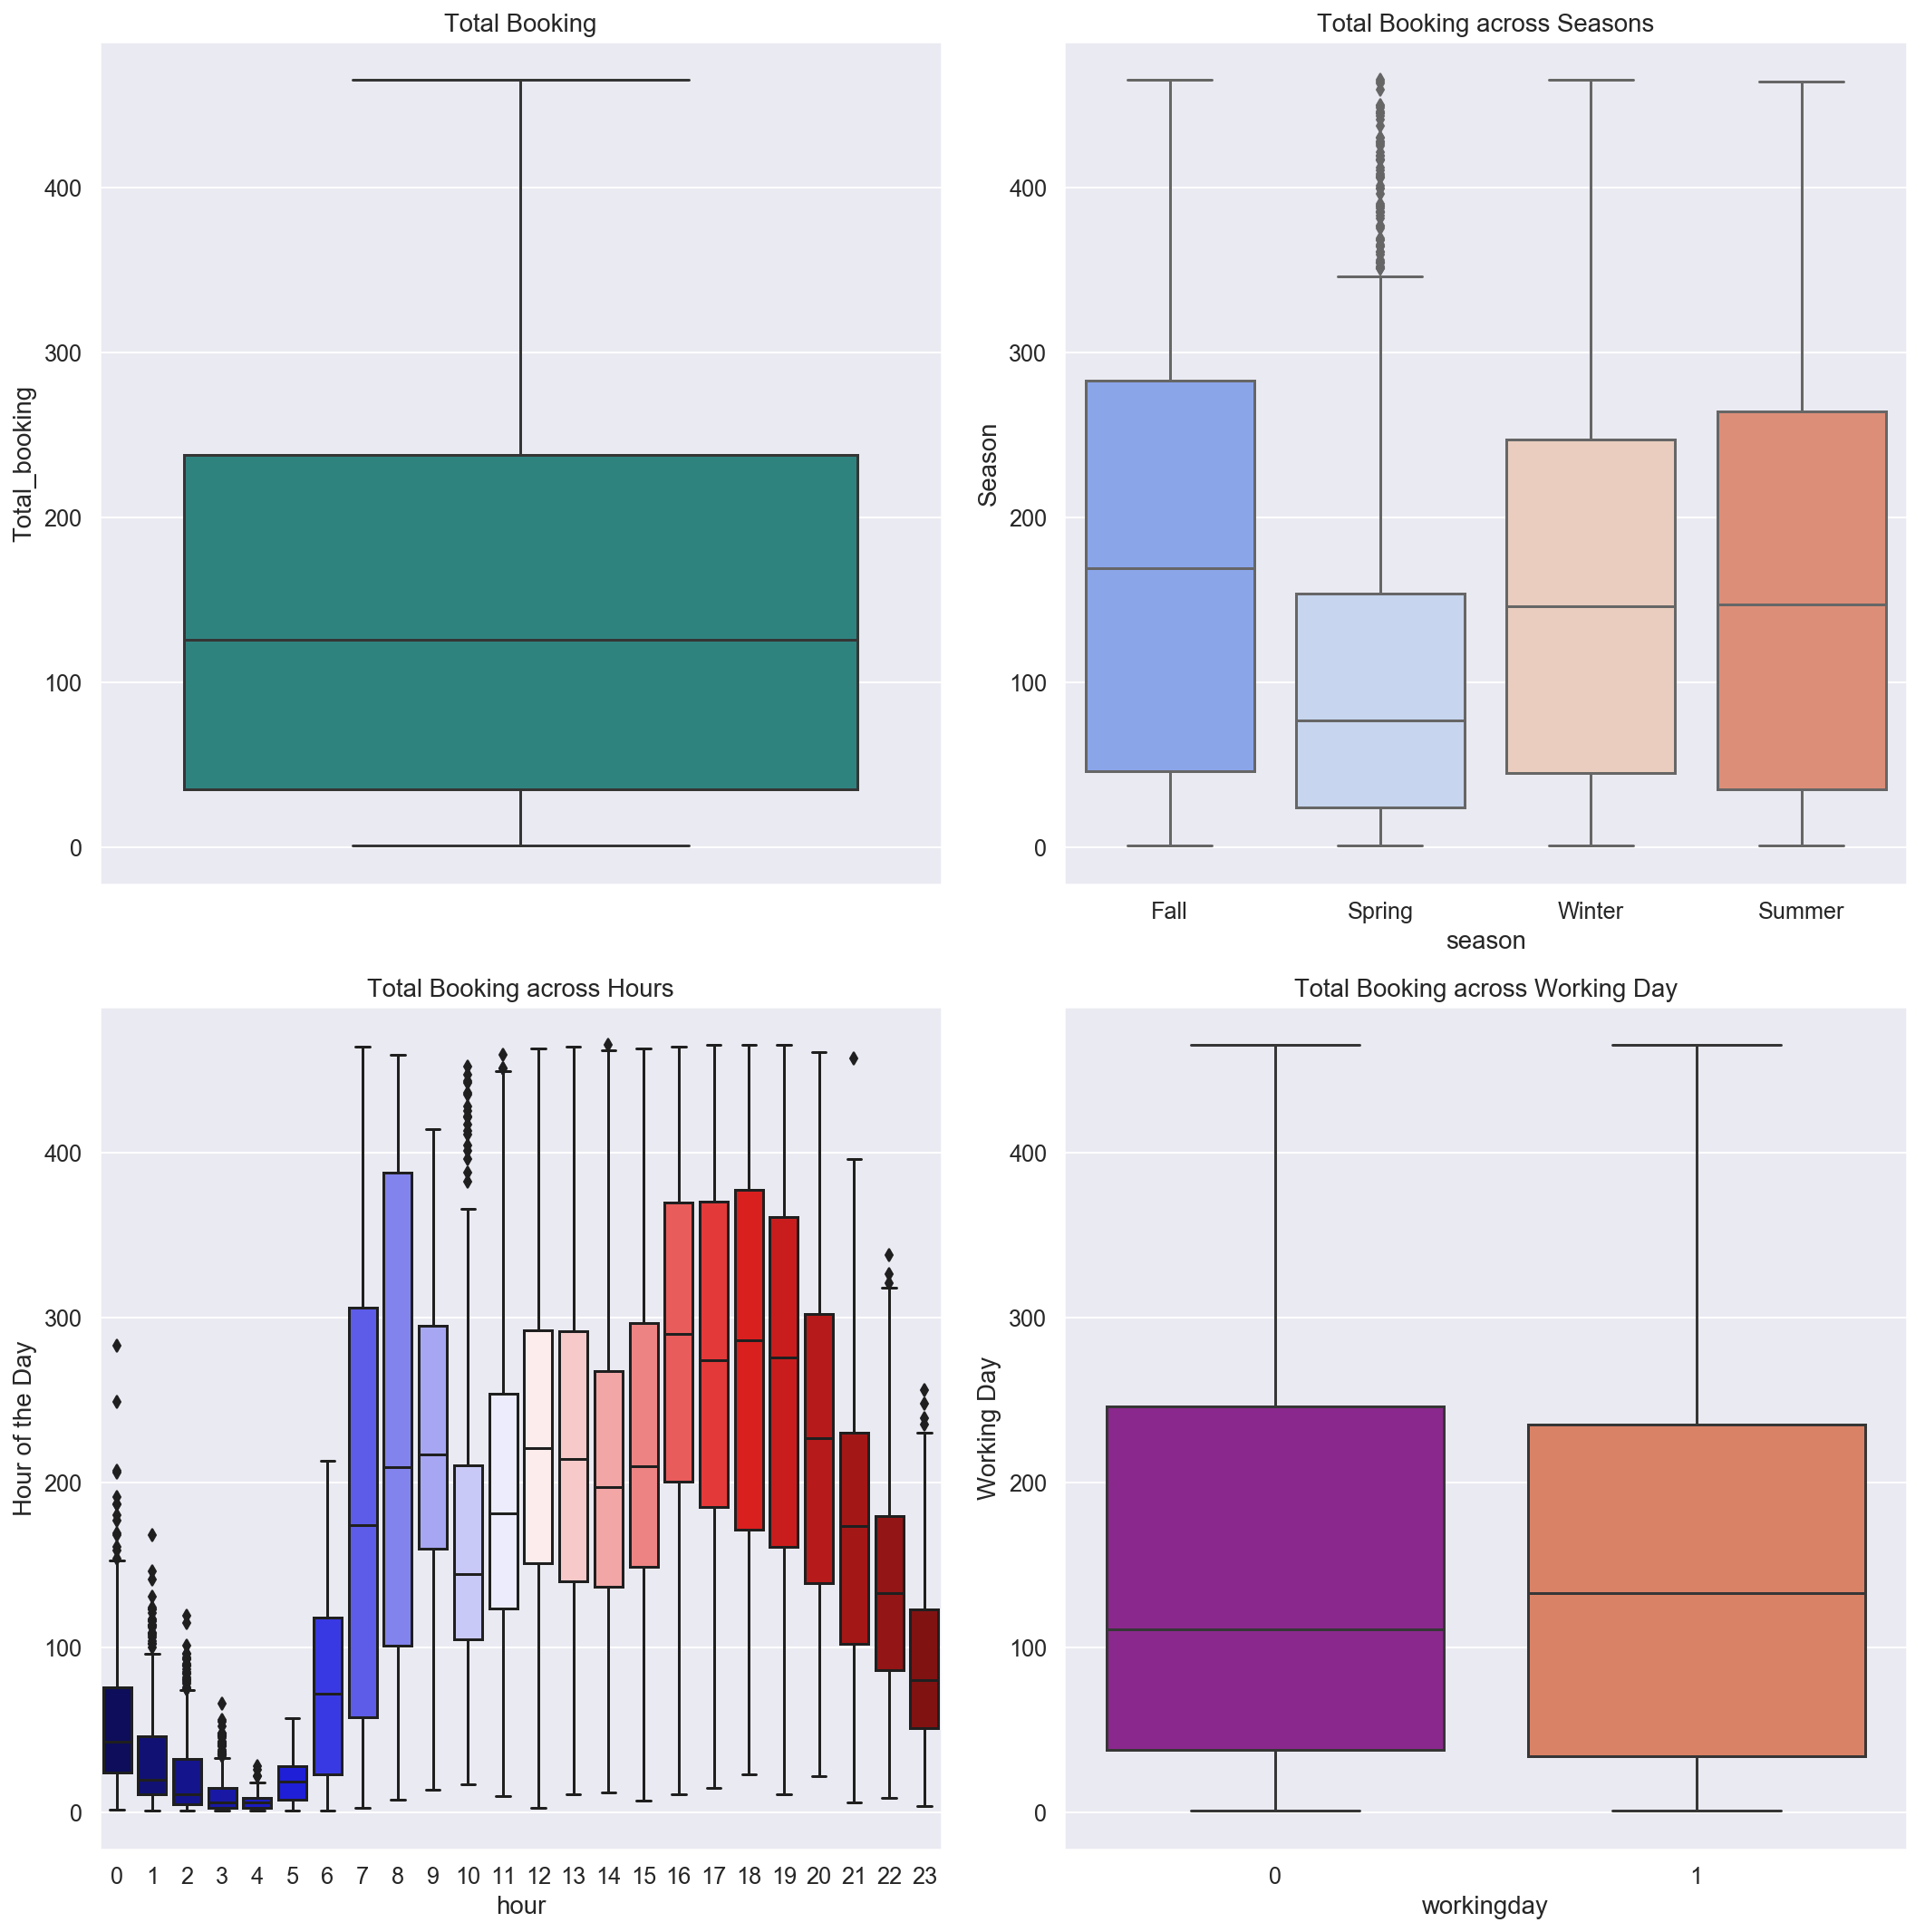

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

sns.boxplot(data=df1, y='Total_booking', orient='v',
            ax=axes[0][0], palette='viridis')

sns.boxplot(data=df1, y='Total_booking', x='season',
            orient='v', ax=axes[0][1], palette='coolwarm')

sns.boxplot(data=df1, y='Total_booking', x='hour',
            orient='v', ax=axes[1][0], palette='seismic')

sns.boxplot(data=df1, y='Total_booking', x='workingday',
            orient='v', ax=axes[1][1], palette='plasma')

axes[0][0].set(ylabel='Total_booking', title='Total Booking')
axes[0][1].set(ylabel='Season', title='Total Booking across Seasons')
axes[1][0].set(ylabel='Hour of the Day', title='Total Booking across Hours')
axes[1][1].set(ylabel='Working Day', title='Total Booking across Working Day')

plt.tight_layout()
plt.show()

#### Insights - After removing the Outliers
1. Cab booking is higher on Working day but min-max range is very close.
2. Significant outlier data have been removed from Morning peak hours

### Target Variable Distribution

Text(0.5,1,'Target Variable Distribution with Outliers')

[Text(0,0.5,'Bookings'), Text(0.5,0,'Frequency')]

Text(0.5,1,'Target Variable Distribution without Outliers')

[Text(0,0.5,'Bookings'), Text(0.5,0,'Frequency')]

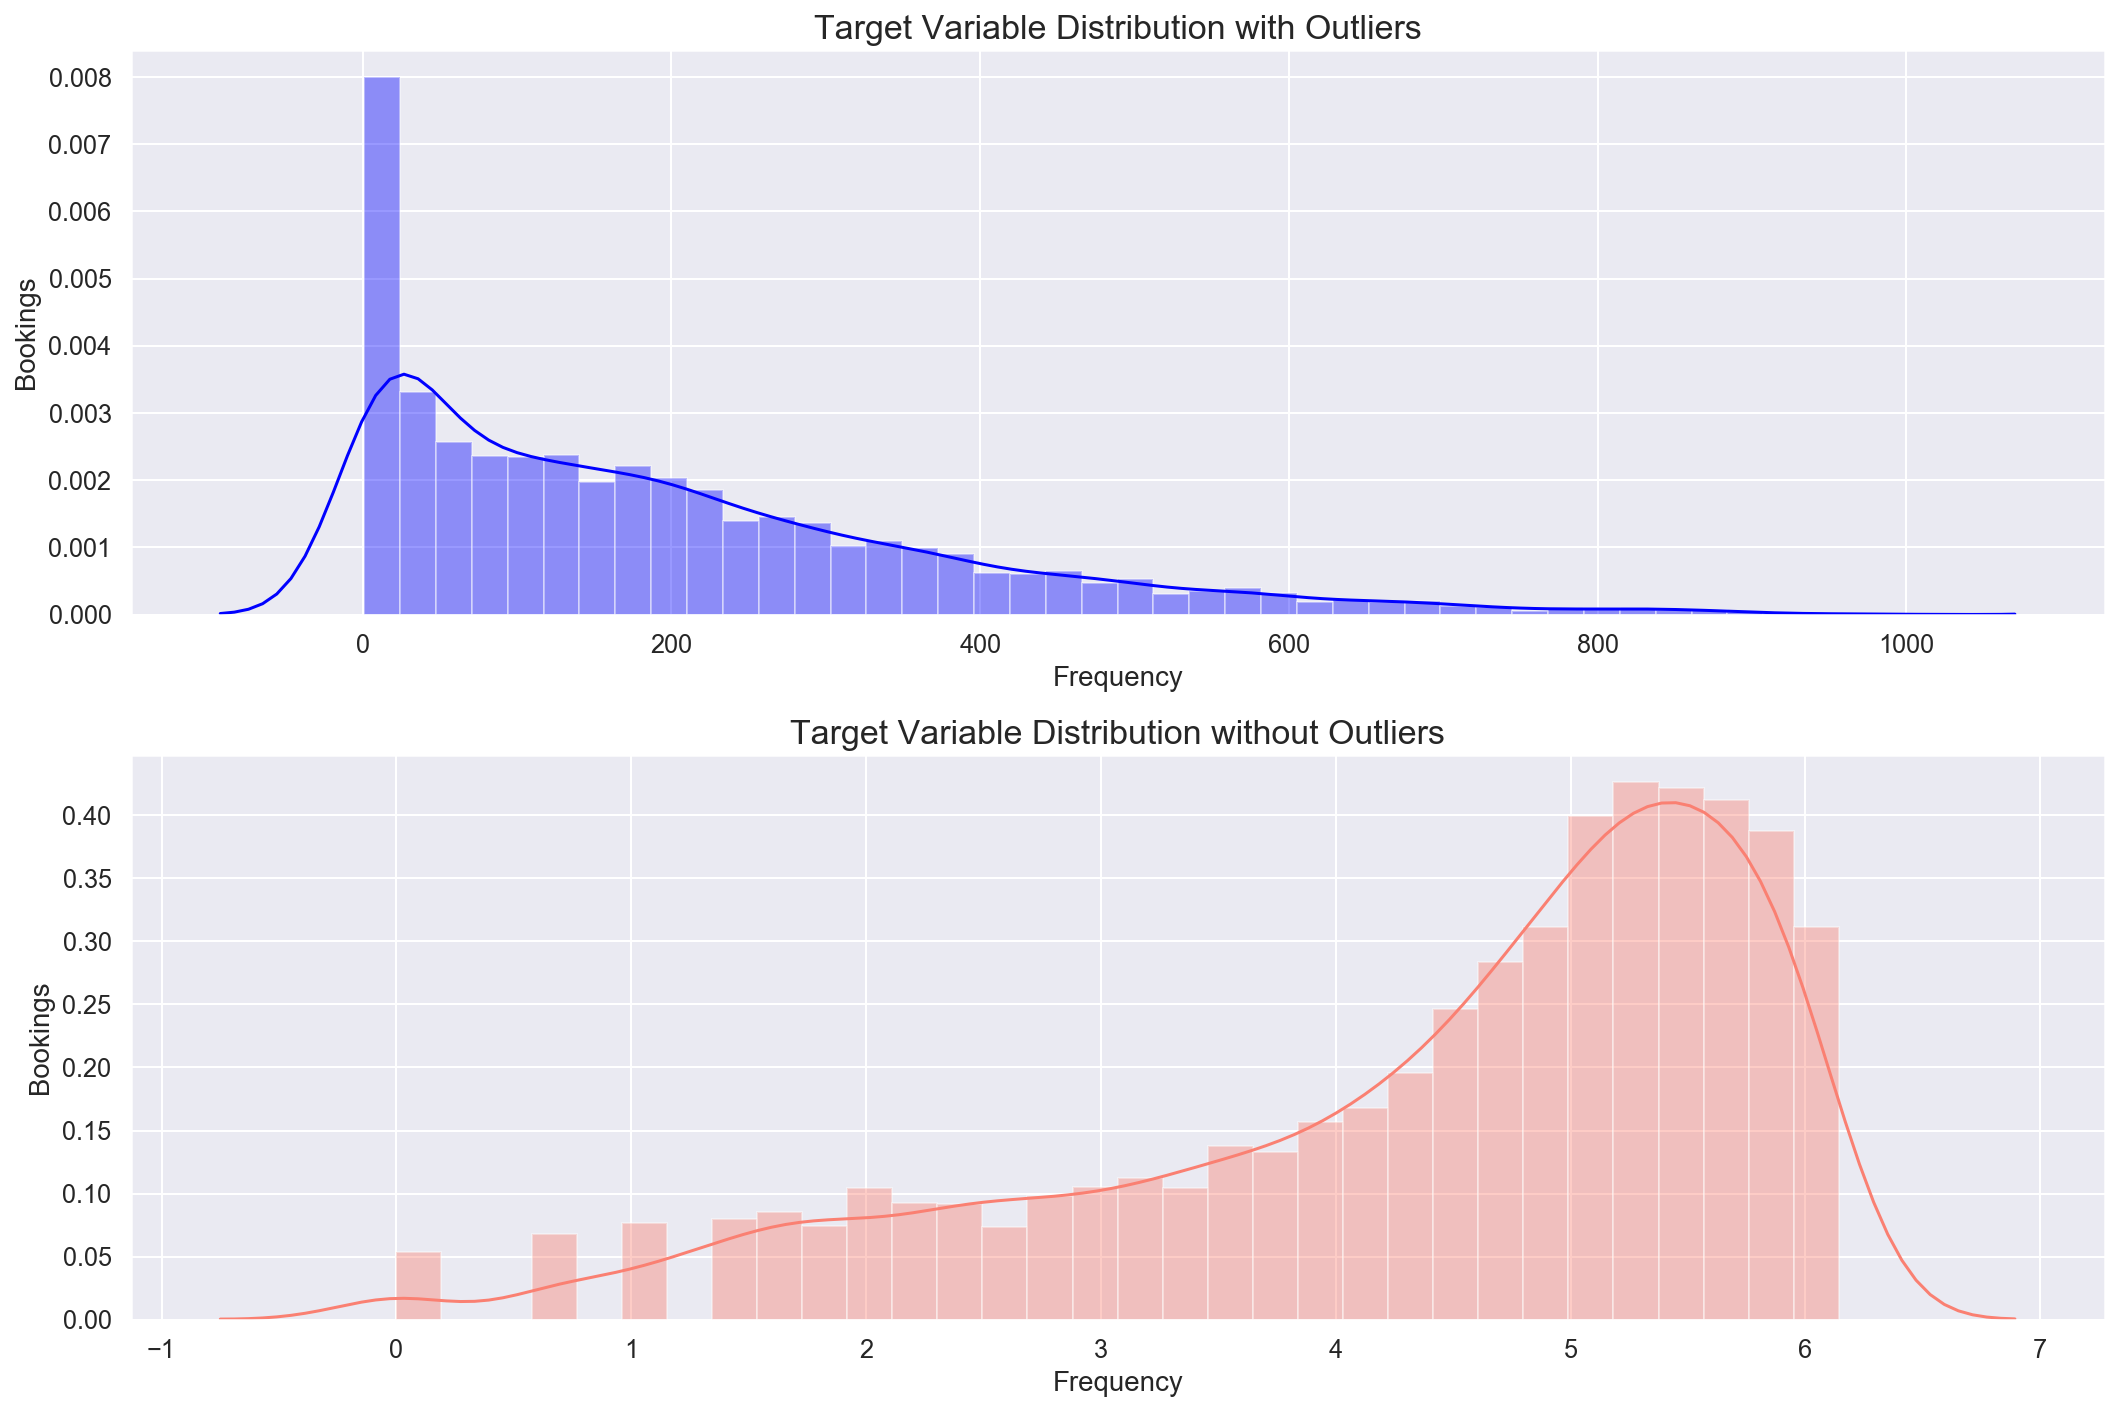

In [41]:
fig, (ax01, ax010) = plt.subplots(nrows=2, figsize=(15, 10))

sns.distplot(df['Total_booking'], ax=ax01, color='blue')
sns.distplot(np.log(df1['Total_booking']), ax=ax010, color='salmon')

ax01.set_title('Target Variable Distribution with Outliers', fontsize=17)
ax01.set(xlabel='Frequency', ylabel='Bookings')

ax010.set_title('Target Variable Distribution without Outliers', fontsize=17)
ax010.set(xlabel='Frequency', ylabel='Bookings')

plt.tight_layout()
plt.show()

#### Insights
1. Total Booking is right-skewed
2. Log transformation post outlier removal also could not normalize the distribution

# TASK - 2

## Feature Engineering
    - Already performed in Task - 1

## Grid Search

In [42]:
df.weather.unique()

array([' Clear + Few clouds', ' Light Snow, Light Rain',
       ' Mist + Cloudy ', ' Heavy Rain + Thunderstorm '], dtype=object)

In [43]:
df1['season'] = df1.season.map(
    {'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4})

df1['weather'] = df1.weather.map({' Clear + Few clouds': 1,
                                  ' Light Snow, Light Rain': 2,
                                  ' Mist + Cloudy ': 3,
                                  ' Heavy Rain + Thunderstorm ': 4})

In [44]:
dv1['season'] = dv1.season.map(
    {'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4})

dv1['weather'] = dv1.weather.map({' Clear + Few clouds': 1,
                                  ' Light Snow, Light Rain': 2,
                                  ' Mist + Cloudy ': 3,
                                  ' Heavy Rain + Thunderstorm ': 4})

In [45]:
X_train = df1.drop(['Total_booking', 'temp'], axis=1)
y_train = df1.Total_booking

X_test = dv1.drop(['Total_booking', 'temp'], axis=1)
y_test = dv1.Total_booking

In [46]:
X_train.shape, y_train.shape

((7909, 12), (7909,))

In [47]:
X_test.shape, y_test.shape

((1969, 12), (1969,))

### Grid Search Hyperparamter Tuning

In [48]:
def linear_regressions(xtr, xt, ytr, yt):
    
    start = time.time()

    tuners = [{'alpha': [1, 30, 40, 50, 60, 70],
               'max_iter': [1, 5, 7, 9, 10, 11]}]
    clf0 = LinearRegression()
    clf1 = GridSearchCV(estimator=Ridge(), param_grid=tuners)
    clf2 = GridSearchCV(estimator=Lasso(), param_grid=tuners)

    clf0.fit(xtr, ytr)
    clf1.fit(xtr, ytr)
    clf2.fit(xtr, ytr)

    prd0 = clf0.predict(xt)
    prd1 = clf1.predict(xt)
    prd2 = clf2.predict(xt)

    print(f'Best Ridge: {clf1.best_params_}')
    print(f'Best Lasso: {clf2.best_params_}')

    lintr = round(clf0.score(xtr, ytr), 3)
    ridgetr = round(clf1.score(xtr, ytr), 3)
    lastr = round(clf2.score(xtr, ytr), 3)

    lintes = round(clf0.score(xt, yt), 3)
    ridgetes = round(clf1.score(xt, yt), 3)
    lastes = round(clf2.score(xt, yt), 3)

    rmse0 = round(np.sqrt(mean_squared_error(yt, prd0)), 3)
    rmse1 = round(np.sqrt(mean_squared_error(yt, prd1)), 3)
    rmse2 = round(np.sqrt(mean_squared_error(yt, prd2)), 3)

    mae0 = round(mean_absolute_error(yt, prd0), 3)
    mae1 = round(mean_absolute_error(yt, prd1), 3)
    mae2 = round(mean_absolute_error(yt, prd2), 3)

    allscores = pd.DataFrame({'Training R2': [lintr, ridgetr, lastr],
                              'Test R2': [lintes, ridgetes, lastes],
                              'RMSE': [rmse0, rmse1, rmse2],
                              'MAE': [mae0, mae1, mae2],
                              'Models': ['Linear', 'Ridge', 'Lasso']
                              })

    allscores.set_index('Models', drop=True, inplace=True)
    t_allscores = allscores.drop(['Training R2', 'Test R2'], axis=1)
    z_allscores = allscores.drop(['RMSE', 'MAE'], axis=1)
    
    t_allscores.plot(kind='bar', rot=0, figsize=(12, 4), colormap='Pastel2',
                     title='Regression Error Metrics Comparison')
    z_allscores.plot(kind='bar', rot=0, figsize=(12, 4), colormap='Set3',
                     title='Regression Accuracy Metrics Comparison')
    
    end = time.time()
    
    print("Execution time: {0:.5} seconds \n".format(end-start))
    return allscores

Best Ridge: {'alpha': 50, 'max_iter': 1}
Best Lasso: {'alpha': 1, 'max_iter': 7}
Execution time: 1.3145 seconds 



,Training R2,Test R2,RMSE,MAE
Models,,,,
Linear,0.399,0.399,94.894,74.039
Ridge,0.399,0.400,94.889,74.032
Lasso,0.398,0.399,94.935,74.083


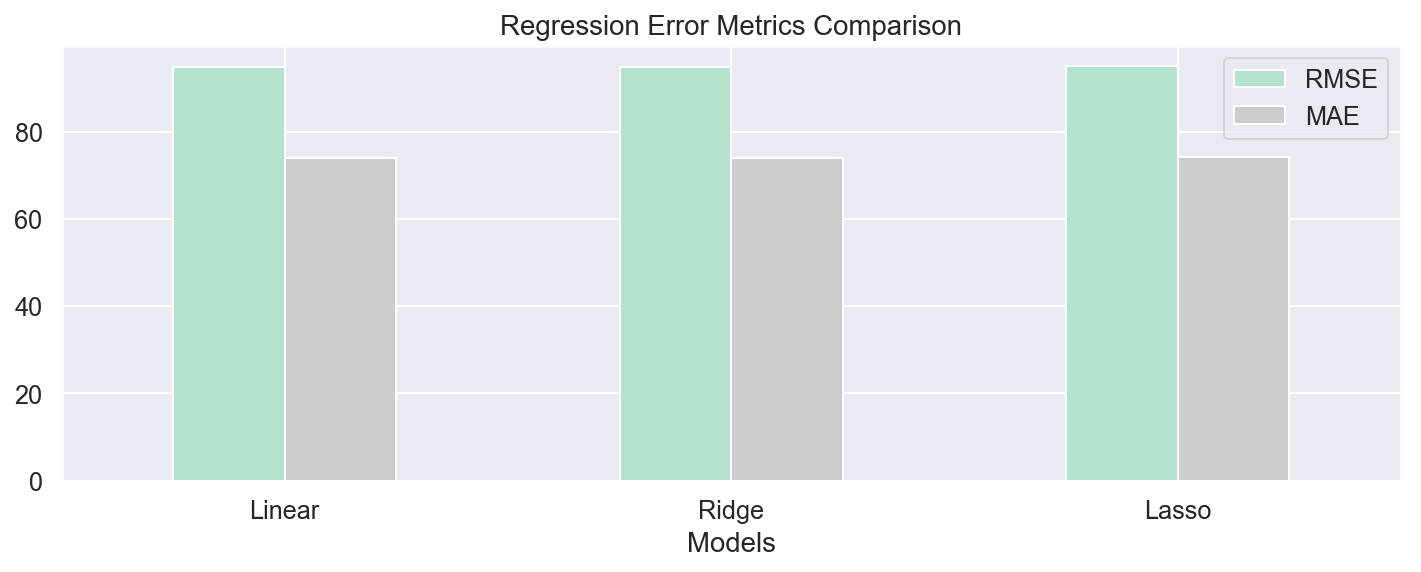

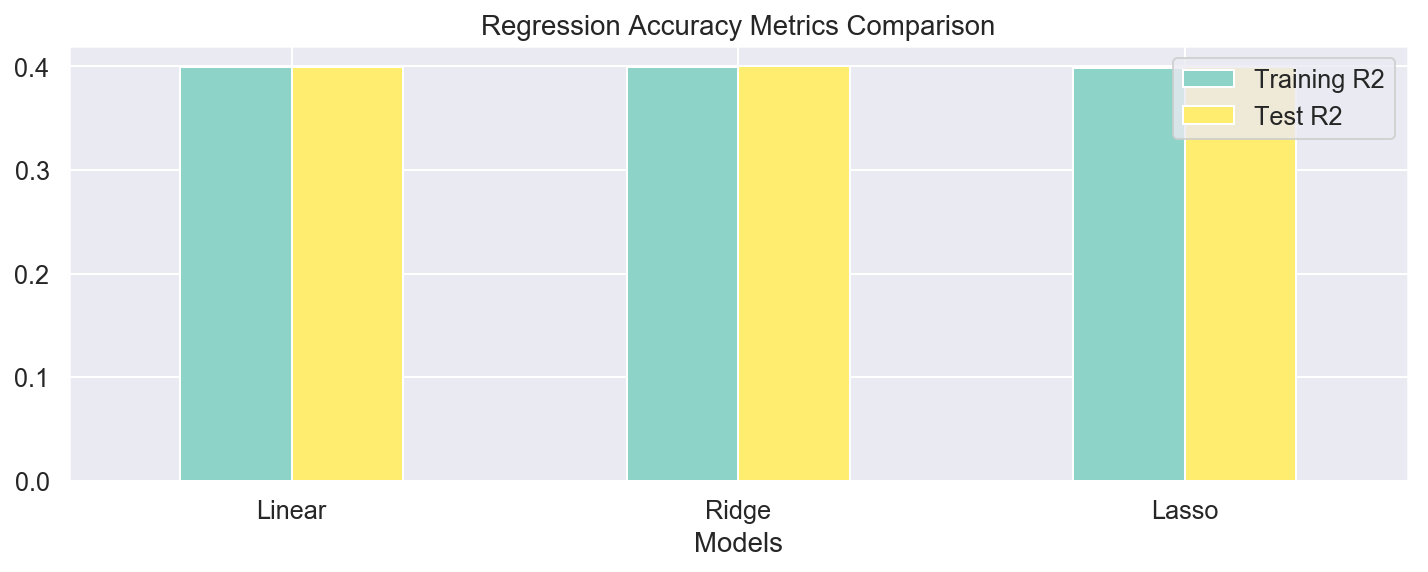

In [49]:
linear_regressions(X_train, X_test, y_train, y_test)

#### Insights
1. All the models have poor accuracy score

## Ensemble Models

In [50]:
def ensemble_regressions(xtr, xt, ytr, yt):
    
    start = time.time()

    tuner1 = [{'n_estimators': [100, 200, 300, 400, 500]}]
    tuner2 = [{'n_estimators': [1100, 1300, 1500],
               'learning_rate': [0.1, 0.25, 0.35, 0.5]}]
    tuner3 = [{'n_estimators': [50, 100, 150, 200],
               'learning_rate': [0.1, 0.25, 0.5, 0.7]}]

    clf1 = GridSearchCV(estimator=RandomForestRegressor(
        random_state=1), param_grid=tuner1, n_jobs=-1)

    clf2 = GridSearchCV(estimator=GradientBoostingRegressor(),
                        param_grid=tuner2, n_jobs=-1)

    clf3 = GridSearchCV(estimator=AdaBoostRegressor(),
                        param_grid=tuner3, n_jobs=-1)

    clf1.fit(xtr, ytr)
    clf2.fit(xtr, ytr)
    clf3.fit(xtr, ytr)

    prd1 = clf1.predict(xt)
    prd2 = clf2.predict(xt)
    prd3 = clf3.predict(xt)

    print(f'Best Random Forest: {clf1.best_params_}')
    print(f'Best Gradient Boosting: {clf2.best_params_}')
    print(f'Best AdaBoost: {clf3.best_params_}')

    rf_tr = round(clf1.score(xtr, ytr), 3)
    gr_tr = round(clf2.score(xtr, ytr), 3)
    ad_tr = round(clf3.score(xtr, ytr), 3)

    rf_te = round(clf1.score(xt, yt), 3)
    gr_te = round(clf2.score(xt, yt), 3)
    ad_te = round(clf3.score(xt, yt), 3)

    rmse1 = round(np.sqrt(mean_squared_error(yt, prd1)), 3)
    rmse2 = round(np.sqrt(mean_squared_error(yt, prd2)), 3)
    rmse3 = round(np.sqrt(mean_squared_error(yt, prd3)), 3)

    mae1 = round(mean_absolute_error(yt, prd1), 3)
    mae2 = round(mean_absolute_error(yt, prd2), 3)
    mae3 = round(mean_absolute_error(yt, prd3), 3)

    allscores = pd.DataFrame({'Random Forest': [rf_tr, rf_te, rmse1, mae1],
                              'Gradient Boosting': [gr_tr, gr_te, rmse2, mae2],
                              'AdaBoost': [ad_tr, ad_te, rmse3, mae3],
                              'Scores': ['Training-R2', 'Test-R2', 'RMSE', 'MAE']
                              })

    allscores.set_index('Scores', drop=True, inplace=True)
    t_allscores = allscores.drop(['RMSE', 'MAE'], axis=0)
    z_allscores = allscores.drop(['Training-R2', 'Test-R2'], axis=0)

    t_allscores.plot(kind='bar', rot=0, figsize=(12, 4), colormap='Set2',
                     title='Ensemble Accuracy Metrics Comparison')
    z_allscores.plot(kind='bar', rot=0, figsize=(12, 4), colormap='Set3',
                     title='Ensemble Error Metrics Comparison')
    
    end = time.time()
    
    print("Execution time: {0:.5} seconds \n".format(end-start))

    return allscores

Best Random Forest: {'n_estimators': 500}
Best Gradient Boosting: {'learning_rate': 0.25, 'n_estimators': 1300}
Best AdaBoost: {'learning_rate': 0.7, 'n_estimators': 50}
Execution time: 97.561 seconds 



,Random Forest,Gradient Boosting,AdaBoost
Scores,,,
Training-R2,0.989,0.963,0.623
Test-R2,0.927,0.924,0.603
RMSE,33.095,33.788,77.154
MAE,21.328,23.645,59.502


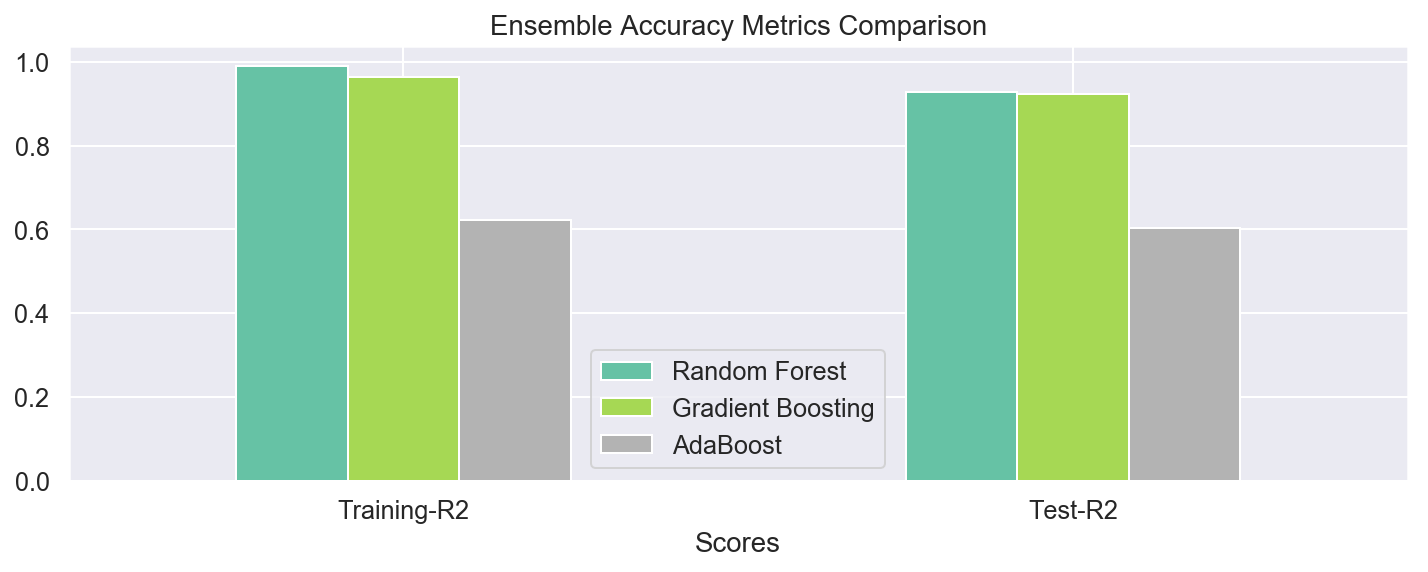

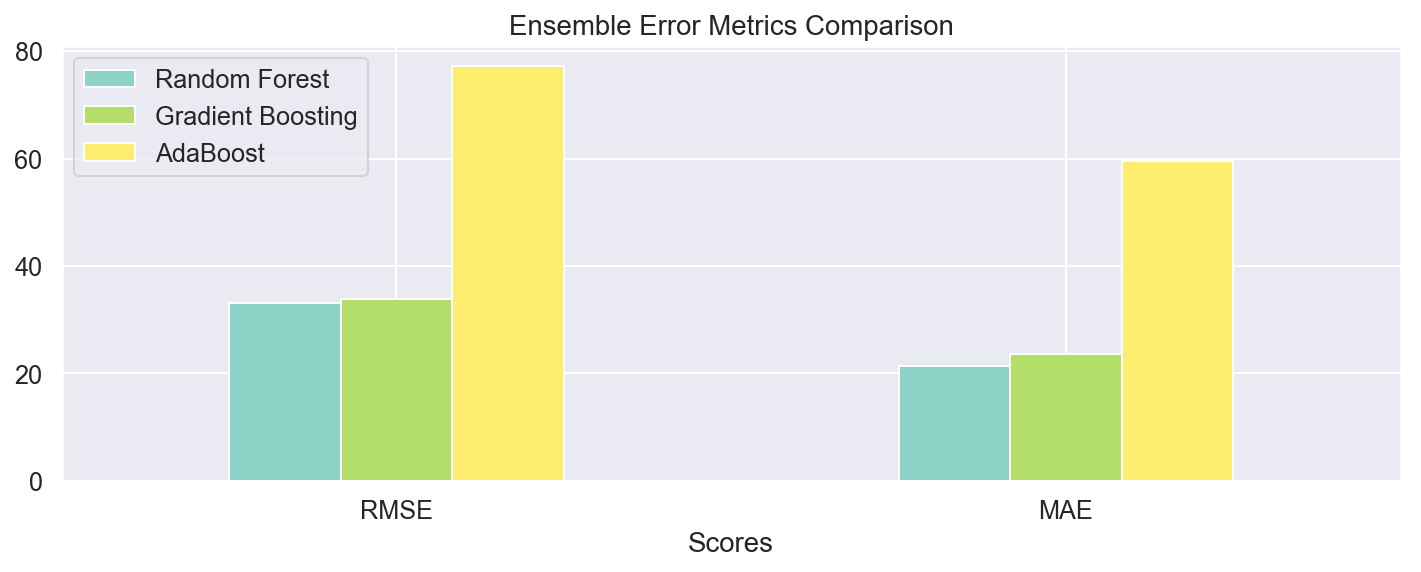

In [51]:
ensemble_regressions(X_train, X_test, y_train, y_test)

#### Insights
1. Best Model - Random Forest
2. AdaBoost - returned a poor model over Decision Tree but with a good fit.

## Other Popular Models - XGBoost, LightGBM and CatBoost

In [52]:
def popular_regressions(xtr, xt, ytr, yt):
    
    start = time.time()

    tuner1 = [{'n_estimators': [100, 200, 300, 400, 500],
               'learning_rate': [0.1, 0.25, 0.35, 0.5]}]

    tuner_k = [{'n_neighbors': [5, 10, 20, 30, 50], 'p': [1, 2, 3, 4]}]

    tuner_c = [{'depth': [6, 8, 10], 'learning_rate': [
        0.01, 0.05, 0.1], 'iterations': [30, 50, 100]}]

    clf1 = GridSearchCV(estimator=XGBRegressor(
        objective='reg:squarederror', random_state=1), param_grid=tuner1, n_jobs=-1)

    clf2 = GridSearchCV(estimator=LGBMRegressor(),
                        param_grid=tuner1, n_jobs=-1)

    clf3 = GridSearchCV(estimator=CatBoostRegressor(),
                        param_grid=tuner_c, cv=2, n_jobs=-1)

    clf1.fit(xtr, ytr)
    clf2.fit(xtr, ytr)
    clf3.fit(xtr, ytr)

    prd1 = clf1.predict(xt)
    prd2 = clf2.predict(xt)
    prd3 = clf3.predict(xt)

    print(f'Best XGB: {clf1.best_params_}')
    print(f'Best LGB: {clf2.best_params_}')
    print(f'Best Cat: {clf3.best_params_}')

    xg_tr = round(clf1.score(xtr, ytr), 3)
    lg_tr = round(clf2.score(xtr, ytr), 3)
    ct_tr = round(clf2.score(xtr, ytr), 3)

    xg_te = round(clf1.score(xt, yt), 3)
    lg_te = round(clf2.score(xt, yt), 3)
    ct_te = round(clf2.score(xt, yt), 3)

    rmse1 = round(np.sqrt(mean_squared_error(yt, prd1)), 3)
    rmse2 = round(np.sqrt(mean_squared_error(yt, prd2)), 3)
    rmse3 = round(np.sqrt(mean_squared_error(yt, prd3)), 3)

    mae1 = round(mean_absolute_error(yt, prd1), 3)
    mae2 = round(mean_absolute_error(yt, prd2), 3)
    mae3 = round(mean_absolute_error(yt, prd3), 3)

    allscores = pd.DataFrame({'XGBoost': [xg_te, xg_te, rmse1, mae1],
                              'LightGBM': [lg_tr, lg_te, rmse2, mae2],
                              'CatBoost': [ct_tr, ct_te, rmse3, mae3],
                              'Scores': ['Training-R2', 'Test-R2', 'RMSE', 'MAE']
                              })

    allscores.set_index('Scores', drop=True, inplace=True)
    t_allscores = allscores.drop(['RMSE', 'MAE'], axis=0)
    z_allscores = allscores.drop(['Training-R2', 'Test-R2'], axis=0)

    t_allscores.plot(kind='bar', rot=0, figsize=(12, 4), colormap='Set2',
                     title='Accuracy Metrics Comparison')
    z_allscores.plot(kind='bar', rot=0, figsize=(12, 4), colormap='Set3',
                     title='Error Metrics Comparison')
    
    end = time.time()
    
    print("Execution time: {0:.5} seconds \n".format(end-start))

    return allscores

0:	learn: 117.6537135	total: 62.5ms	remaining: 6.19s
1:	learn: 110.6049794	total: 67.1ms	remaining: 3.29s
2:	learn: 103.3593442	total: 70.8ms	remaining: 2.29s
3:	learn: 96.7808875	total: 74.4ms	remaining: 1.78s
4:	learn: 91.0119941	total: 77.8ms	remaining: 1.48s
5:	learn: 86.3097440	total: 82ms	remaining: 1.28s
6:	learn: 81.4147152	total: 85.5ms	remaining: 1.14s
7:	learn: 76.8901954	total: 88.9ms	remaining: 1.02s
8:	learn: 72.7525138	total: 92.6ms	remaining: 937ms
9:	learn: 69.1568860	total: 96.7ms	remaining: 870ms
10:	learn: 66.7324691	total: 100ms	remaining: 810ms
11:	learn: 64.5795912	total: 104ms	remaining: 760ms
12:	learn: 62.3114386	total: 107ms	remaining: 716ms
13:	learn: 59.8532208	total: 111ms	remaining: 682ms
14:	learn: 58.2429238	total: 118ms	remaining: 667ms
15:	learn: 56.1100137	total: 123ms	remaining: 648ms
16:	learn: 54.5390756	total: 127ms	remaining: 620ms
17:	learn: 52.8568063	total: 131ms	remaining: 595ms
18:	learn: 51.2912380	total: 135ms	remaining: 573ms
19:	learn: 

,XGBoost,LightGBM,CatBoost
Scores,,,
Training-R2,0.917,0.984,0.984
Test-R2,0.917,0.945,0.945
RMSE,35.245,28.670,31.206
MAE,24.876,18.643,21.325


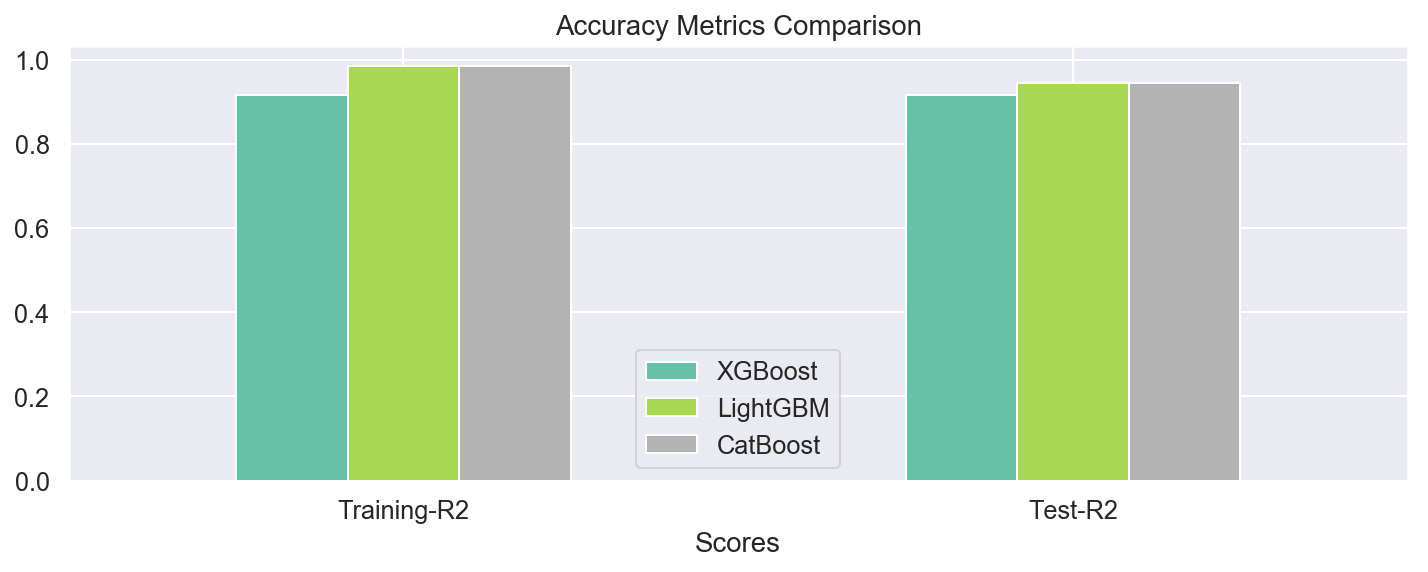

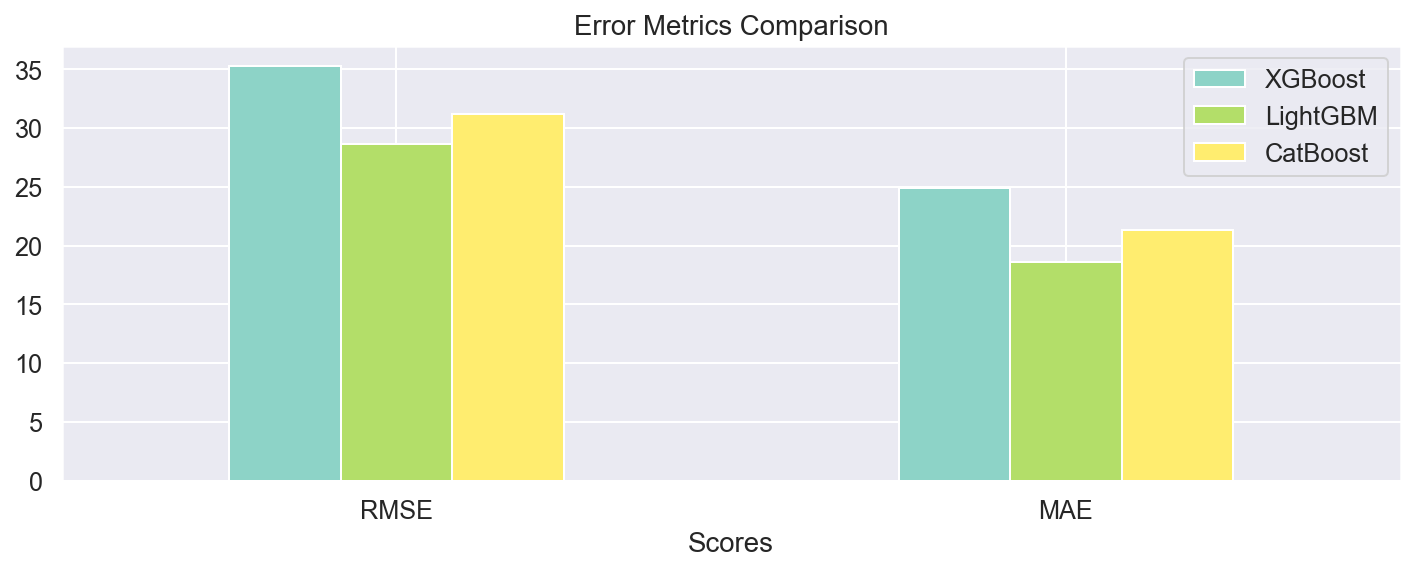

In [53]:
popular_regressions(X_train, X_test, y_train, y_test)

#### Insights
1. As expected LightGBM and CatBoost outperforms Regression, Ensemble models including XGBoost.
2. RMSE and MAE values are also the lowest for the LightGBM
3. The execution time wise 
    - Regression Models are fastest with 1.3145 seconds
    - XGB, LGBM and CatBoost fared average with 55.79 seconds
    - Ensemble Models performed worst and took 97.561 seconds

## ----------------------------------------------- END -----------------------------------------------------